# Setup

In [1]:
!pip install Wikipedia-API wordfreq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Created wheel for Wikipedia-API: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15384 sha256=610ece24f07ead679d9043dbecd7bed314b4c7582437dbf65221bf39cc68e158
  Stored in directory: /root/.cache/pip/wheels/1d/f8/07/0508c38722dcd82ee355e9d85e33c9e9471d4bec0f8ae72de0
Successfully built Wikipedia-API


In [2]:
import os
import ast
import json
import nltk
import time
import fsspec
import requests
import wikipediaapi

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

from gensim.models import KeyedVectors
from numberbatch_uri import standardized_uri

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict, Counter

from statsmodels.stats.contingency_tables import mcnemar, SquareTable

from google import genai
from google.cloud import storage, bigquery
from google.genai.types import CreateBatchJobConfig

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Load Sentence-BERT model
sbert_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Load Base Latent Hatred Dataset

In [ ]:
stg1_ids = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg1.tsv", sep="\t")
stg1 = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg1_posts.tsv", sep="\t")
stg1["ID"] = stg1_ids["ID"].astype(str)

stg2_ids = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg2.tsv", sep="\t")
stg2 = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg2_posts.tsv", sep="\t")
stg2["ID"] = stg2_ids["ID"].astype(str)

stg3_ids = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg3.tsv", sep="\t")
stg3 = pd.read_csv("implicit-hate-corpus\implicit_hate_v1_stg3_posts.tsv", sep="\t")
stg3["ID"] = stg3_ids["ID"].astype(str)

df = pd.merge(stg1, stg2, on="ID", how="outer").merge(stg3, on="ID", how="outer")

df["post"] = df["post_x"]
df = df[["ID", "post", "class", "target", "implied_statement", "implicit_class", "extra_implicit_class"]]
df.dropna(thresh=2, inplace=True)
df.to_csv("datasets/LH_base.csv", index=False)
df

In [28]:
lh = pd.read_csv("/kaggle/input/msc-thesis/LH_base.csv")
lh["binary_class"] = [label if label == "not_hate" else "hate" for label in lh['class']]
lh.drop(columns=["target", "implied_statement", "extra_implicit_class"], inplace=True)
lh

,ID,post,class,implicit_class,binary_class
0,399886440588247041,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,hate
1,929901925100937216,b.higher education is a part of european cult...,not_hate,NaN,not_hate
2,728678509497954304,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,not_hate
3,625688620444180481,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,not_hate
4,441089979322597376,"rt "" : how three million germans mass murder...",not_hate,NaN,not_hate
...,...,...,...,...,...
21475,SAP_17154,"Seeing prostitutes is morally wrong, but being...",implicit_hate,irony,hate
21476,SAP_17179,I wonder how many females I raped today I spen...,implicit_hate,irony,hate
21477,SAP_17314,Having a criminal record is more attractive to...,implicit_hate,stereotypical,hate
21478,SAP_17343,Another advantage of being a female: getting b...,implicit_hate,inferiority,hate


### Train Test Split

In [29]:
train, test = train_test_split(lh, test_size=0.2, stratify=lh["class"], random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Load MAMI Dataset

In [6]:
path = "/kaggle/input/msc-thesis/MAMI/"
mami_train = pd.concat([pd.read_csv(path + "train.tsv", sep="\t"), pd.read_csv(path + "validation.tsv", sep="\t")])["file_name"]
mami_test = pd.read_csv(path + "test.tsv", sep="\t")["file_name"]

In [7]:
mami = pd.read_csv("/kaggle/input/msc-thesis/MAMI_texts_and_descs.csv")
mami["post"] = (mami["extracted text"] + " " + mami["image description"]).str.replace("\n", " ")
label_cols = ['shaming', 'stereotype', 'objectification', 'violence']
mami

,meme id,extracted text,image description,misogyny,shaming,stereotype,objectification,violence,post
0,1.jpg,Milk\nMilk.zip,A pitcher of milk and a block of cheese sit si...,not misogynous,0,0,0,0,Milk Milk.zip A pitcher of milk and a block of...
1,10.jpg,"ROSES ARE RED, VIOLETS\nARE BLUE\nIF YOU DON'T...",A panda is leaning against a tree stump with a...,misogynous,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,BREAKING NEWS: Russia releases photo of DONALD...,A woman in a tank top and skirt is massaging a...,not misogynous,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,MAN SEEKING WOMAN,A man is being thrown through the wall as a wo...,not misogynous,0,0,0,0,MAN SEEKING WOMAN A man is being thrown throug...
4,10006.jpg,Me explaining the\ndeep lore of J.R.R.\nTolkei...,Mr. Krabs and Spongebob are sitting near a fir...,not misogynous,0,0,0,0,Me explaining the deep lore of J.R.R. Tolkein'...
...,...,...,...,...,...,...,...,...,...
10990,15591.jpg,IT'S NOT YOUR FAULT\nYou didn't design the dre...,A woman wearing a purple and gray low-cut dres...,misogynous,0,1,1,0,IT'S NOT YOUR FAULT You didn't design the dres...
10991,15049.jpg,THINK ABOUT HOW MUCH\nBETTER HER SKIN IS\nBREA...,A woman with freckles is staring at the camera.\n,not misogynous,0,0,0,0,THINK ABOUT HOW MUCH BETTER HER SKIN IS BREATH...
10992,15363.jpg,THE STEREOTYPES ARE TRUE\nSHE DOES HAVE A TIGH...,An Asian woman with dark hair has a toothpick ...,misogynous,0,1,1,0,THE STEREOTYPES ARE TRUE SHE DOES HAVE A TIGHT...
10993,15199.jpg,DRAWS NAKED PICTURES\nOF BLACK WOMEN\nGETS MAD...,A man wearing a head wrap and necklace is talk...,not misogynous,0,0,0,0,DRAWS NAKED PICTURES OF BLACK WOMEN GETS MAD W...


In [8]:
mami_train, mami_test = train_test_split(mami, test_size=0.2, stratify=mami["misogyny"], random_state=42)
mami_train = mami_train.reset_index(drop=True)
mami_test = mami_test.reset_index(drop=True)

#mami_train = pd.merge(mami_train, mami, left_on="file_name", right_on="meme id", how="left").drop(columns=["file_name"])
#mami_test = pd.merge(mami_test, mami, left_on="file_name", right_on="meme id", how="left").drop(columns=["file_name"])

## Initialise Model

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  # No activation
        )

    def forward(self, x):
        return self.model(x)

In [10]:
def train_and_report(train, test, label_cols, plot_loss=False, runs=5, multilabel=False, printing=True):
    if multilabel:
        
        train = train[train["misogyny"] == "misogynous"]
        test = test[test["misogyny"] == "misogynous"]
        
        train = train.dropna(subset=label_cols)
        test = test.dropna(subset=label_cols)
        
        y_train_all = train[label_cols].astype(float).values
        y_test_all = test[label_cols].astype(float).values

        num_classes = len(label_cols)
        
    else:
        train = train.dropna(subset=[label_cols])
        test = test.dropna(subset=[label_cols])

        le = LabelEncoder()
        le.fit(train[label_cols])
        y_train_all = le.transform(train[label_cols])
        y_test_all = le.transform(test[label_cols])
        num_classes = len(le.classes_)

    # Feature tensors
    X_train = torch.tensor(np.vstack(train["embeddings"].values), dtype=torch.float32)
    X_test = torch.tensor(np.vstack(test["embeddings"].values), dtype=torch.float32)

    # Label tensors
    if multilabel:
        y_train = torch.tensor(y_train_all, dtype=torch.float32)
        y_test = torch.tensor(y_test_all, dtype=torch.float32)
    else:
        y_train = torch.tensor(y_train_all, dtype=torch.long)
        y_test = torch.tensor(y_test_all, dtype=torch.long)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_reports = []
    all_losses = []
    best_f1 = -1
    best_y_true = None
    best_preds = None

    for run in range(runs):
        model = MLP(X_train.shape[1], num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss() if multilabel else nn.CrossEntropyLoss()

        X_tr, y_tr = X_train.to(device), y_train.to(device)
        X_te, y_te = X_test.to(device), y_test.to(device)

        losses = []
        for epoch in range(500 if multilabel else 200):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_tr)
            loss = criterion(outputs, y_tr)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        all_losses.append(losses)

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(X_te)
            if multilabel:
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).int().cpu().numpy()
                y_true = y_te.cpu().numpy()
                report_dict = classification_report(
                    y_true,
                    preds,
                    target_names=label_cols,
                    output_dict=True,
                    zero_division=0
                )
                labels = label_cols

            else:
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_true = y_te.cpu().numpy()
                report_dict = classification_report(
                    y_true,
                    preds,
                    target_names=le.classes_,
                    output_dict=True,
                    zero_division=0
                )
                labels = le.classes_

            f1 = np.mean([report_dict[label]['f1-score'] for label in labels])
            if f1 > best_f1:
                best_f1 = f1
                best_y_true = y_true
                best_preds = preds

            all_reports.append(report_dict)

    # Average classification report
    avg_report = defaultdict(lambda: defaultdict(float))
    for report in all_reports:
        for label, scores in report.items():
            if isinstance(scores, dict):
                for metric, value in scores.items():
                    avg_report[label][metric] += value

    for label, scores in avg_report.items():
        for metric in scores:
            avg_report[label][metric] /= runs

    macro_precision = np.mean([avg_report[label]['precision'] for label in labels])
    macro_recall = np.mean([avg_report[label]['recall'] for label in labels])
    macro_f1 = np.mean([avg_report[label]['f1-score'] for label in labels])

    if printing:
        print("\n=== Average Classification Report over", runs, "runs ===\n")
        for label in labels:
            metrics = avg_report[label]
            print(f"{label:20s}  P: {metrics['precision']:.2f}  R: {metrics['recall']:.2f}  F1: {metrics['f1-score']:.2f}")
    
        print(f"\nMacro Avg             P: {macro_precision:.2f}  R: {macro_recall:.2f}  F1: {macro_f1:.2f}")

    if plot_loss:
        print()
        plt.figure(figsize=(8, 5))
        for i, losses in enumerate(all_losses):
            plt.plot(losses, label=f"Run {i+1}")
        plt.title("Training Loss per Run")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if not printing:
        return best_y_true, best_preds, labels

---

# Baselines

## Zero-Context Model

In [11]:
def get_embeddings(texts):
    """Encode text using Sentence-BERT."""
    return pd.Series(list(
        sbert_model.encode([str(text) for text in texts], 
                           device="cuda", 
                           convert_to_numpy=True, 
                           batch_size=64)))

### LH ZC

In [18]:
train["embeddings"] = get_embeddings(train["post"])
test["embeddings"] = get_embeddings(test["post"])

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [12]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.67  R: 0.64  F1: 0.65
not_hate              P: 0.78  R: 0.80  F1: 0.79

Macro Avg             P: 0.73  R: 0.72  F1: 0.72
Weighted Avg          P: 0.74  R: 0.74  F1: 0.74


In [13]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.53  R: 0.53  F1: 0.53
inferiority           P: 0.46  R: 0.56  F1: 0.51
irony                 P: 0.58  R: 0.55  F1: 0.56
other                 P: 0.23  R: 0.16  F1: 0.19
stereotypical         P: 0.57  R: 0.57  F1: 0.57
threatening           P: 0.56  R: 0.57  F1: 0.57
white_grievance       P: 0.63  R: 0.60  F1: 0.61

Macro Avg             P: 0.51  R: 0.51  F1: 0.51
Weighted Avg          P: 0.56  R: 0.56  F1: 0.56


### MAMI ZC

In [13]:
mami_train["embeddings"] = get_embeddings(list(zip(mami_train["extracted text"], mami_train["image description"])))
mami_test["embeddings"] = get_embeddings(list(zip(mami_test["extracted text"], mami_test["image description"])))

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


=== Average Classification Report over 5 runs ===

misogynous            P: 0.79  R: 0.80  F1: 0.79
not misogynous        P: 0.80  R: 0.78  F1: 0.79

Macro Avg             P: 0.79  R: 0.79  F1: 0.79



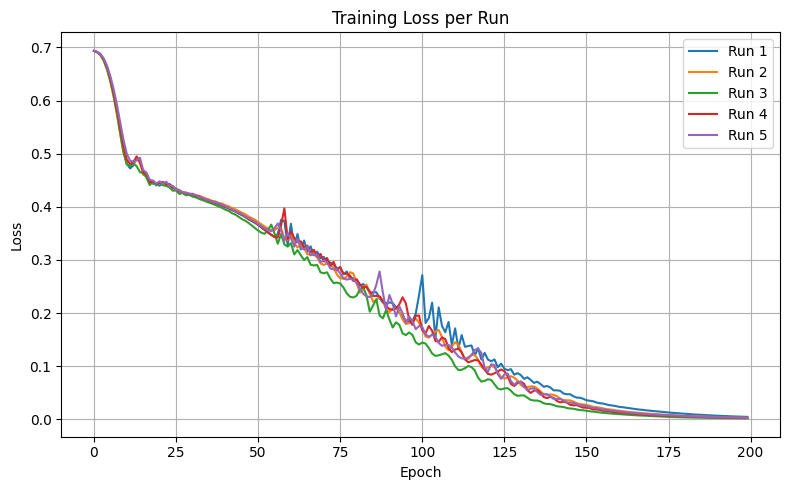

In [14]:
train_and_report(mami_train, mami_test, "misogyny", plot_loss=True)

In [16]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.48  R: 0.42  F1: 0.45
stereotype            P: 0.66  R: 0.69  F1: 0.68
objectification       P: 0.66  R: 0.69  F1: 0.67
violence              P: 0.58  R: 0.50  F1: 0.54

Macro Avg             P: 0.59  R: 0.58  F1: 0.58
Weighted Avg          P: 0.62  R: 0.62  F1: 0.62


---

## REL (Lin Replication)

In [ ]:
# Wikipedia API setup
wiki_wiki = wikipediaapi.Wikipedia(user_agent='NLPContextExtraction', language='en')

In [27]:
API_URL = "https://rel.cs.ru.nl/api"

def call_rel(text_doc):
    """Call the REL API."""
    req = requests.post(API_URL, json={
        "text": text_doc,
    })
    if req != []:
        return req.json()
    else:
        return []

def get_wikipedia_description(entity):
    """Retrieve first two sentences from Wikipedia summary."""
    page = wiki_wiki.page(entity)
    if page.exists():
        return page.summary[:page.summary.find(". ", page.summary.find(". ") + 1) + 1]
    return ""

def extract_entity_knowledge(text):
    """Extract linked entities from text using REL."""
    try:
        mentions = call_rel(text)
        wiki_names = [e[3] for e in mentions if e[4] > 0.2 and e[5] > 0.4]
        knowledge_text = " ".join([get_wikipedia_description(e) for e in wiki_names])
        return knowledge_text
    except:
        return ""

### LH REL

In [ ]:
train["wiki_desc"] = train['post'].apply(extract_entity_knowledge)
test["wiki_desc"] = test['post'].apply(extract_entity_knowledge)

df_rel = df.merge(train[["ID", "wiki_desc"]], on="ID", how="left").merge(test[["ID", "wiki_desc"]], on="ID", how="left")
df_rel["wiki_desc"].fillna("", inplace=True)

df_rel.to_csv("datasets/LH_REL.csv", index=False)

In [17]:
lh_rel = pd.read_csv("/kaggle/input/msc-thesis/LH_REL.csv")

lh_rel = lh_rel.fillna("")

train = train.merge(lh_rel[["ID", "wiki_desc"]], on="ID", how="left")
test = test.merge(lh_rel[["ID", "wiki_desc"]], on="ID", how="left")

In [18]:
train["embeddings"] = get_embeddings(list(zip(train["post"], train['wiki_desc'].astype("str"))))
test["embeddings"] = get_embeddings(list(zip(test["post"], test['wiki_desc'].astype("str"))))

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [198]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.64  R: 0.61  F1: 0.63
not_hate              P: 0.77  R: 0.79  F1: 0.78

Macro Avg             P: 0.71  R: 0.70  F1: 0.70
Weighted Avg          P: 0.72  R: 0.72  F1: 0.72


In [199]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.51  R: 0.52  F1: 0.51
inferiority           P: 0.43  R: 0.52  F1: 0.47
irony                 P: 0.53  R: 0.53  F1: 0.53
other                 P: 0.22  R: 0.12  F1: 0.15
stereotypical         P: 0.53  R: 0.51  F1: 0.52
threatening           P: 0.54  R: 0.55  F1: 0.55
white_grievance       P: 0.59  R: 0.55  F1: 0.57

Macro Avg             P: 0.48  R: 0.47  F1: 0.47
Weighted Avg          P: 0.53  R: 0.52  F1: 0.52


### MAMI REL

In [19]:
mami_rel = pd.read_csv("/kaggle/input/msc-thesis/MAMI_REL.csv").fillna("")
mami_rel.head()

,meme id,post,misogyny,shaming,stereotype,objectification,violence,wiki_desc
0,1.jpg,Milk Milk.zip. a pitcher of milk and a piece o...,not misogynous,0,0,0,0,
1,10.jpg,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...",misogynous,0,0,0,1,
2,1000.jpg,BREAKING NEWS: Russia releases photo of DONALD...,not misogynous,0,0,0,0,"Russia, or the Russian Federation, is a countr..."
3,10000.jpg,MAN SEEKING WOMAN Ignad 18 O. a man jumping in...,not misogynous,0,0,0,0,"Edward Osborne Wilson (June 10, 1929 – Decemb..."
4,10006.jpg,Me explaining the deep lore of. J.R.R. Tolkein...,not misogynous,0,0,0,0,"John Ronald Reuel Tolkien (, 3 January 1892 – ..."


In [20]:
mami_train = mami_train.merge(mami_rel[["meme id", "wiki_desc"]], on="meme id", how="left")
mami_test = mami_test.merge(mami_rel[["meme id", "wiki_desc"]], on="meme id", how="left")

In [21]:
mami_train["embeddings"] = get_embeddings(list(zip(mami_train["extracted text"], mami_train["image description"], mami_train["wiki_desc"])))
mami_test["embeddings"] = get_embeddings(list(zip(mami_test["extracted text"], mami_test["image description"], mami_test["wiki_desc"])))

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [153]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.78  R: 0.79  F1: 0.78
not misogynous        P: 0.79  R: 0.78  F1: 0.78

Macro Avg             P: 0.78  R: 0.78  F1: 0.78
Weighted Avg          P: 0.78  R: 0.78  F1: 0.78


In [154]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.46  R: 0.39  F1: 0.42
stereotype            P: 0.65  R: 0.70  F1: 0.68
objectification       P: 0.64  R: 0.65  F1: 0.65
violence              P: 0.56  R: 0.50  F1: 0.53

Macro Avg             P: 0.58  R: 0.56  F1: 0.57
Weighted Avg          P: 0.60  R: 0.60  F1: 0.60


---

## ConceptNet (ElSherief Replication)

In [22]:
# ConceptNet Numberbatch embeddings
wv = KeyedVectors.load_word2vec_format("/kaggle/input/msc-thesis/numberbatch-en-19.08.txt/numberbatch-en.txt", binary=False)

In [23]:
def get_entity_vector(entity, embeddings):
    """Retrieve entity vector from Word2Vec."""
    if entity in embeddings:
        return embeddings[entity]
    else:
        return np.zeros(300)
    
def get_cn_entities(text):
    words = nltk.word_tokenize(text)
    my_bigrams = list(nltk.bigrams(words)) if len(words) >= 2 else []
    my_trigrams = list(nltk.trigrams(words)) if len(words) >= 3 else []
    entities = []
    for gram in [[word] for word in words] + list(my_bigrams) + list(my_trigrams):
        joined = " ".join(gram)
        uri = standardized_uri("en", joined).split("/")[-1]
        if uri in wv:
            entities.append(uri)
    return list(set(entities))

def avg_and_norm(embeddings):
    """ Normalizes an embedding to unit length. """
    avg = np.mean(embeddings, axis=0)
    norm = np.linalg.norm(avg)
    return avg / norm if norm > 0 else avg

def get_entity_embeddings(entities):
    cn_avg = []
    for cn in list(entities):
        ent_vecs = [get_entity_vector(ent, wv) for ent in cn]
        if ent_vecs != []:
            cn_avg.append(avg_and_norm(ent_vecs))
        else:
            cn_avg.append(np.zeros(300))
    
    return cn_avg

### LH CN

In [24]:
train["cn_entities"] = train['post'].apply(get_cn_entities)
test["cn_entities"] = test['post'].apply(get_cn_entities)

In [25]:
train["cn_avg_vector"] = get_entity_embeddings(train["cn_entities"])
test["cn_avg_vector"] = get_entity_embeddings(test["cn_entities"])

In [26]:
train["base_embeddings"] = get_embeddings(train["post"])
test["base_embeddings"] = get_embeddings(test["post"])

train["embeddings"] = [np.concatenate([a, b]) for a, b in zip(train["base_embeddings"], train["cn_avg_vector"])]
test["embeddings"] = [np.concatenate([a, b]) for a, b in zip(test["base_embeddings"], test["cn_avg_vector"])]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [41]:
train.head()

,index,ID,post,class,implicit_class,binary_class,embeddings,cn_entities,cn_avg_vector,base_embeddings
0,7185,483852414156406784,right on america needs to wake up enough blac...,implicit_hate,white_grievance,hate,"[-0.02926422, 0.12188798, 0.0026721908, -0.013...","[enough, wake, right_on, for, media, and, to, ...","[-0.2175834, -0.23461422, 0.048264507, 0.12033...","[-0.02926422, 0.12188798, 0.0026721908, -0.013..."
1,21216,SAP_10882,LOL EDGY @ein_schoner_tag @shedevil___ @ahptik...,implicit_hate,inferiority,hate,"[0.048663404, 0.012307206, 0.006852489, 0.0049...","[are, but, women, im, sexist, why, allowed, lo...","[-0.1940114, -0.22602883, -0.059176996, -0.105...","[0.048663404, 0.012307206, 0.006852489, 0.0049..."
2,4191,891995990173118464,integration / assimilation will eventually lea...,implicit_hate,white_grievance,hate,"[-0.037049543, 0.12818302, 0.0017129325, -0.01...","[to, will, lead_to, white, lead, extinction, i...","[-0.1897923, -0.073014215, -0.11511584, 0.1430...","[-0.037049543, 0.12818302, 0.0017129325, -0.01..."
3,2266,900473556387147777,he's been spewing hate . i guess that's ok . y...,not_hate,NaN,not_hate,"[-0.052074384, 0.09308696, -0.012015538, 0.029...","[been, safe, your, spewing, white, privilege, ...","[-0.214056, -0.23062544, -0.009021298, 0.01985...","[-0.052074384, 0.09308696, -0.012015538, 0.029..."
4,2699,914604618549743617,vote nelson out ! dem lifer always against pol...,not_hate,NaN,not_hate,"[-0.050566938, 0.06654639, 0.003413869, 0.0014...","[policies, always, vote, against, out, nelson,...","[-0.15320301, -0.23125476, -0.048553932, 0.081...","[-0.050566938, 0.06654639, 0.003413869, 0.0014..."


In [42]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.68  R: 0.66  F1: 0.67
not_hate              P: 0.80  R: 0.81  F1: 0.80

Macro Avg             P: 0.74  R: 0.74  F1: 0.74
Weighted Avg          P: 0.75  R: 0.75  F1: 0.75


In [43]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.52  R: 0.53  F1: 0.53
inferiority           P: 0.50  R: 0.58  F1: 0.54
irony                 P: 0.53  R: 0.59  F1: 0.56
other                 P: 0.18  R: 0.13  F1: 0.15
stereotypical         P: 0.59  R: 0.54  F1: 0.56
threatening           P: 0.58  R: 0.55  F1: 0.56
white_grievance       P: 0.62  R: 0.59  F1: 0.60

Macro Avg             P: 0.50  R: 0.50  F1: 0.50
Weighted Avg          P: 0.56  R: 0.56  F1: 0.56


### MAMI CN

In [27]:
mami_train["cn_entities"] = mami_train['post'].astype(str).apply(get_cn_entities)
mami_test["cn_entities"] = mami_test['post'].astype(str).apply(get_cn_entities)

mami_train["cn_avg_vector"] = get_entity_embeddings(mami_train["cn_entities"])
mami_test["cn_avg_vector"] = get_entity_embeddings(mami_test["cn_entities"])

mami_train["base_embeddings"] = get_embeddings(list(zip(mami_train["extracted text"], mami_train["image description"])))
mami_test["base_embeddings"] = get_embeddings(list(zip(mami_test["extracted text"], mami_test["image description"])))

mami_train["embeddings"] = [np.concatenate([a, b]) for a, b in zip(mami_train["base_embeddings"], mami_train["cn_avg_vector"])]
mami_test["embeddings"] = [np.concatenate([a, b]) for a, b in zip(mami_test["base_embeddings"], mami_test["cn_avg_vector"])]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [28]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.80  R: 0.81  F1: 0.80
not misogynous        P: 0.81  R: 0.79  F1: 0.80

Macro Avg             P: 0.80  R: 0.80  F1: 0.80
Weighted Avg          P: 0.80  R: 0.80  F1: 0.80


In [29]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.47  R: 0.40  F1: 0.43
stereotype            P: 0.67  R: 0.71  F1: 0.69
objectification       P: 0.66  R: 0.69  F1: 0.68
violence              P: 0.61  R: 0.57  F1: 0.59

Macro Avg             P: 0.60  R: 0.60  F1: 0.60
Weighted Avg          P: 0.62  R: 0.63  F1: 0.63


---

# Augmentation by LLM

In [12]:
from kaggle_secrets import UserSecretsClient as USC

PROJECT_ID = "hsd-thesis"

GOOGLE_API_KEY = USC().get_secret("GOOGLE_API_KEY")
USC().set_gcloud_credentials(project=PROJECT_ID)

MODEL_ID = "gemini-2.0-flash-001"
bucket_name = "hsd-general"
BUCKET_URI = "gs://" + bucket_name
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")
stg = storage.Client(PROJECT_ID)

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

In [13]:
def make_batch(texts, fname, system, req):
    batch = []
    for text in texts:
        batch.append({"request":{"contents": [{"role": "user", "parts": [{"text": system + req + str(text)}]}]}})

    with open(fname + ".jsonl", "w") as f:
        for item in batch:
            f.write(json.dumps(item) + "\n")

    return batch


def upload_to_gcs(bucket_name, fname, destination):
    bucket = stg.bucket(bucket_name)
    blob = bucket.blob(destination)
    blob.upload_from_filename(fname + ".jsonl")
    print(f"File {fname} uploaded to gs://{bucket_name}/{destination}")


def request_batch(folder, fname):

    destination = folder + "/" + fname + ".jsonl"
    upload_to_gcs(bucket_name, fname, destination)

    gcs_batch_job = client.batches.create(
        model = MODEL_ID,
        src = BUCKET_URI + "/" + destination,
        config = CreateBatchJobConfig(dest=BUCKET_URI + "/predictions"),
    )
    return gcs_batch_job

def check_batch_progress(job_name):
    gcs_batch_job = client.batches.get(name=job_name)
    if gcs_batch_job.state == "JOB_STATE_SUCCEEDED":
        print("Job succeeded!")
    elif gcs_batch_job.state == "JOB_STATE_FAILED":
        print("Job failed - ERROR")
    else:
        print("In progress...")

def get_bucket_results(blob_name, ofile):
    bucket = stg.bucket(bucket_name)
    output_path = ofile + ".jsonl"

    blob = list(bucket.list_blobs(prefix="prediction"))[-1]
    blob.download_to_filename(output_path)

    df = pd.read_json(output_path, lines=True)
    
    posts = []
    responses = []
    for request, content in zip(df["request"], df["response"]):
        if "candidates" in content and "parts" in content["candidates"][0]["content"]:
            responses.append(content["candidates"][0]["content"]["parts"][0]["text"])
            posts.append(request["contents"][0]["parts"][0]["text"])

    context = pd.DataFrame()

    context["post"] = posts
    context["response"] = responses

    return context

---

# Named Entities

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

ner_tk = AutoTokenizer.from_pretrained("dslim/bert-base-NER-uncased")
bert_ner = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER-uncased")
ner_tagger = pipeline("ner", model=bert_ner, tokenizer=ner_tk, aggregation_strategy="simple")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [39]:
def get_tags(df, col):
    
    results = ner_tagger(list(df[col].astype("str")), batch_size=16)
    simple_tags = [[{tag["word"]: tag["entity_group"]} for tag in sent_tags] for sent_tags in results]

    merged = []
    for span in simple_tags:
        new_span = []
        prev_key = None
        prev_tag = None
        for token in span:
            for word, tag in token.items():
                if word.startswith("##") and prev_tag == tag:
                    # Merge with previous
                    prev_key += word[2:]
                    new_span[-1] = {prev_key: tag}
                else:
                    new_span.append({word: tag})
                    prev_key = word
                    prev_tag = tag
        merged.append(new_span)
    return merged 

In [ ]:
lh_ner = lh.copy()
lh_ner["tags"] = get_tags(lh_ner)
lh_ner.to_csv("LH_NER.csv", index=False)

In [40]:
mami_ner = mami.copy()
mami_ner["tags"] = get_tags(mami_ner, "post")
mami_ner.to_csv("MAMI_NER.csv", index=False)

In [41]:
c = 0
all_tags = []
for tags in mami_ner["tags"]:
    if tags != []:
        c += 1
    all_tags.extend(tags)

print(c)
len(all_tags)

4877


11164

In [52]:
mami_ner[mami_ner['tags'].astype(str).str.contains('trump', na=False)]

,meme id,extracted text,image description,misogyny,shaming,stereotype,objectification,violence,post,tags
2,1000.jpg,BREAKING NEWS: Russia releases photo of DONALD...,A woman in a tank top and skirt is massaging a...,not misogynous,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...,"[{'russia': 'LOC'}, {'donald trump': 'PER'}, {..."
112,10129.jpg,How Democrats see voters\nBlack\n11.6%\nAm Ind...,This image shows two pie charts depicting the ...,not misogynous,0,0,0,0,How Democrats see voters Black 11.6% Am Indian...,"[{'democrats': 'MISC'}, {'am indian': 'MISC'},..."
121,10138.jpg,THAT FACE YOU GET\nWHEN YOU SEE THE GUY WHO SA...,Donald Trump stands with a smile as Barack Oba...,not misogynous,0,0,0,0,THAT FACE YOU GET WHEN YOU SEE THE GUY WHO SAI...,"[{'donald trump': 'PER'}, {'barack obama': 'PE..."
155,10171.jpg,Fake scandals and\nwitch hunts are better than...,"A man sits at a table outside, smiling as he h...",not misogynous,0,0,0,0,Fake scandals and witch hunts are better than ...,"[{'dem': 'ORG'}, {'trump': 'PER'}]"
349,10365.jpg,I'M CONFLICTED WHEN IT COMES TO\nABORTION. ON ...,"A meme shows a thinking dinosaur, a Wikipedia ...",misogynous,0,1,0,1,I'M CONFLICTED WHEN IT COMES TO ABORTION. ON O...,"[{'wikipedia': 'ORG'}, {'free encyclopedia': '..."
...,...,...,...,...,...,...,...,...,...,...
9653,9650.jpg,SJWS\nARE RUINING\nGAMES WITH\nFEMINISM\nAND C...,"In this four-panel image, a cartoon character ...",not misogynous,0,0,0,0,SJWS ARE RUINING GAMES WITH FEMINISM AND COLOR...,"[{'s': 'ORG'}, {'trump': 'PER'}, {'trump': 'PE..."
9871,9870.jpg,I WANT TRUMP\nTO WIN\nBUT I HAVE A FEELING BID...,A black bear rests on a log and looks worried.\n,not misogynous,0,0,0,0,I WANT TRUMP TO WIN BUT I HAVE A FEELING BIDEN...,"[{'trump': 'PER'}, {'biden': 'PER'}, {'democra..."
9880,9881.jpg,The Snowflake Meltdown Begins\nNo Collusion\nN...,"A person is lying on the ground, appearing dis...",not misogynous,0,0,0,0,The Snowflake Meltdown Begins No Collusion No ...,"[{'russia': 'LOC'}, {'trump': 'PER'}, {'americ..."
10628,15867.jpg,When you sit next to a girl\nand she moves awa...,Donald Trump is speaking in front of a blue ba...,not misogynous,0,0,0,0,When you sit next to a girl and she moves away...,[{'donald trump': 'PER'}]


In [34]:
from collections import Counter

Counter([list(tag.keys())[0] for tag in all_tags]).most_common(10)

[('anime', 131),
 ('spongebob', 82),
 ('corona', 81),
 ('trump', 66),
 ('donald trump', 65),
 ('chinese', 62),
 ('michelle obama', 58),
 ('american', 54),
 ('me', 52),
 ('god', 48)]

In [38]:
from collections import Counter

Counter([list(tag.keys())[0] for tag in all_tags]).most_common(10)

[('corona', 68),
 ('trump', 57),
 ('chinese', 49),
 ('covid', 43),
 ('china', 39),
 ('asian', 35),
 ('god', 32),
 ('karen', 31),
 ('japanese', 30),
 ('american', 29)]

In [30]:
from collections import Counter

Counter([list(tag.keys())[0] for tag in all_tags]).most_common(10)

[('anime', 130),
 ('spongebob', 78),
 ('donald trump', 55),
 ('spongebob squarepants', 44),
 ('me', 37),
 ('star wars', 35),
 ('squidward', 33),
 ('michelle obama', 32),
 ('thanos', 32),
 ('gordon ramsay', 29)]

In [47]:
df_ner = pd.read_csv("/kaggle/input/msc-thesis/LH_NER.csv")
train = train.merge(df_ner[["ID", "tags"]], on="ID", how="left")
test = test.merge(df_ner[["ID", "tags"]], on="ID", how="left")
df_ner.head()

,ID,post,class,target,implied_statement,implicit_class,extra_implicit_class,tags
0,399886440588247041,""" : jewish harvard professor noel ignatiev w...",implicit_hate,Jews,Jews are oppressors,white_grievance,NaN,"[{'jewish': 'MISC'}, {'harvard': 'ORG'}, {'noe..."
1,929901925100937216,b.higher education is a part of european cult...,not_hate,NaN,NaN,NaN,NaN,"[{'european': 'MISC'}, {'asian': 'MISC'}, {'as..."
2,728678509497954304,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,NaN,NaN,NaN,[{'christians': 'MISC'}]
3,625688620444180481,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,NaN,NaN,NaN,"[{'yasir qadhi': 'PER'}, {'christians': 'MISC'..."
4,441089979322597376,"rt "" : how three million germans mass murder...",not_hate,NaN,NaN,NaN,NaN,"[{'germans': 'MISC'}, {'reich': 'LOC'}]"


In [32]:
df_ner[df_ner["tags"].str.len() > 3]

,ID,post,class,target,implied_statement,implicit_class,extra_implicit_class,tags
0,399886440588247041,""" : jewish harvard professor noel ignatiev w...",implicit_hate,Jews,Jews are oppressors,white_grievance,NaN,"[{'jewish': 'MISC'}, {'harvard': 'ORG'}, {'noe..."
1,929901925100937216,b.higher education is a part of european cult...,not_hate,NaN,NaN,NaN,NaN,"[{'european': 'MISC'}, {'asian': 'MISC'}, {'as..."
2,728678509497954304,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,NaN,NaN,NaN,[{'christians': 'MISC'}]
3,625688620444180481,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,NaN,NaN,NaN,"[{'yasir qadhi': 'PER'}, {'christians': 'MISC'..."
4,441089979322597376,"rt "" : how three million germans mass murder...",not_hate,NaN,NaN,NaN,NaN,"[{'germans': 'MISC'}, {'reich': 'LOC'}]"
...,...,...,...,...,...,...,...,...
21466,SAP_16670,Why do women always show there curves Every ti...,implicit_hate,NaN,NaN,inferiority,NaN,[{'islamic': 'MISC'}]
21467,SAP_16706,"Shower Thought: If feminism is cancer, is that...",implicit_hate,NaN,NaN,irony,NaN,[{'shower': 'ORG'}]
21468,SAP_16938,Normies live in constant fear because their gi...,implicit_hate,NaN,NaN,inferiority,NaN,[{'west': 'LOC'}]
21472,SAP_17044,Every woman claims she was raped or sexually h...,implicit_hate,NaN,NaN,irony,NaN,[{'chad': 'LOC'}]


In [36]:
system = "You are a system that finds and adds context to tweets, in order to detect whether they are likely to contain hate speech. You respond briefly with a plaintext paragraph and stick to the facts.\n\n"
req_ner = "Below is a list of Named Entities (and their tags) extracted from a tweet. Provide background context about these entities and how they might relate to hate speech.\n\n"
fname = "ne_request"

df_with_nes = df_ner[df_ner["tags"].str.len() > 3]

batch = make_batch(df_with_nes["tags"].astype(str), fname, system, req_ner)

job = request_batch("entities", fname)
print(job.name)

File ne_request uploaded to gs://hsd-general/entities/ne_request.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/8302373148414705664


In [40]:
check_batch_progress(job.name)

Job succeeded!


In [41]:
ne_results = get_bucket_results(bucket_name, "ne_output")
ne_results["tags"] = [post[-1] for post in ne_results["post"].str.split("\n\n")]
ne_results

,post,response,tags
0,You are a system that finds and adds context t...,"The hashtag ""#a"" is sometimes used as a shorth...","[{'##a': 'MISC'}, {'white supremac': 'MISC'}]"
1,You are a system that finds and adds context t...,* **##adi:** I am unable to find information...,"[{'##adi': 'MISC'}, {'muslim': 'MISC'}, {'do':..."
2,You are a system that finds and adds context t...,"The term ""##ander"" is often used as a suffix i...",[{'##ander': 'MISC'}]
3,You are a system that finds and adds context t...,"I am sorry, but I am unable to provide any con...",[{'##ape': 'LOC'}]
4,You are a system that finds and adds context t...,"The terms ""Muslim"" and ""Islam"" refer to the re...","[{'##at': 'MISC'}, {'muslim': 'MISC'}, {'islam..."
...,...,...,...
14353,You are a system that finds and adds context t...,Matt O'Brien is a journalist who has written a...,"[{""matt o ' brien"": 'PER'}, {'john kelly': 'PE..."
14354,You are a system that finds and adds context t...,The Quran is the central religious text of Isl...,"[{""qur ' an"": 'MISC'}]"
14355,You are a system that finds and adds context t...,"The terms ""Satan"" and ""Islam"" appearing togeth...","[{""satan '"": 'MISC'}, {'islam': 'MISC'}]"
14356,You are a system that finds and adds context t...,"The phrase ""white man's revolution"" can be ass...","[{""white man ' s revolution"": 'MISC'}]"


In [48]:
train = train.merge(ne_results[["tags", "response"]], on="tags", how="left").drop_duplicates(subset=["post", "tags"]).reset_index()
test = test.merge(ne_results[["tags", "response"]], on="tags", how="left").drop_duplicates(subset=["post", "tags"]).reset_index()

In [49]:
train.fillna({"response": ""}, inplace=True)
test.fillna({"response": ""}, inplace=True)

## NE Append & Embed

In [63]:
train["embeddings"] = get_embeddings(list(zip(train["post"], train['response'].astype(str))))
test["embeddings"] = get_embeddings(list(zip(test["post"], test['response'].astype(str))))

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [51]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.64  R: 0.62  F1: 0.63
not_hate              P: 0.77  R: 0.78  F1: 0.78

Macro Avg             P: 0.70  R: 0.70  F1: 0.70


In [52]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.49  R: 0.49  F1: 0.49
inferiority           P: 0.45  R: 0.52  F1: 0.48
irony                 P: 0.55  R: 0.54  F1: 0.54
other                 P: 0.12  R: 0.08  F1: 0.10
stereotypical         P: 0.55  R: 0.52  F1: 0.54
threatening           P: 0.49  R: 0.50  F1: 0.50
white_grievance       P: 0.59  R: 0.58  F1: 0.58

Macro Avg             P: 0.46  R: 0.46  F1: 0.46


## NE Embed & Concat

In [53]:
train["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(train["post"]), get_embeddings(train["response"]))]
test["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(test["post"]), get_embeddings(test["response"]))]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [54]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.66  R: 0.66  F1: 0.66
not_hate              P: 0.79  R: 0.79  F1: 0.79

Macro Avg             P: 0.73  R: 0.73  F1: 0.73


In [55]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.52  R: 0.51  F1: 0.52
inferiority           P: 0.45  R: 0.53  F1: 0.48
irony                 P: 0.53  R: 0.52  F1: 0.53
other                 P: 0.10  R: 0.07  F1: 0.08
stereotypical         P: 0.53  R: 0.52  F1: 0.53
threatening           P: 0.52  R: 0.51  F1: 0.52
white_grievance       P: 0.59  R: 0.57  F1: 0.58

Macro Avg             P: 0.46  R: 0.46  F1: 0.46


## NE Context-Embed

In [56]:
model_name = "sentence-transformers/all-mpnet-base-v2"

context_encoder = SentenceTransformer(model_name)
message_encoder = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
context_encoder.to(device)
message_encoder.to(device)

print(f"Using device: {device}")

Using device: cuda


In [57]:
def get_context_embedding(context):
    """Use SBERT to encode the context into a single vector"""
    
    context_embedding = context_encoder.encode(context, convert_to_tensor=True, show_progress_bar = False)
    context_embedding = context_embedding.to(device)
    
    return context_embedding


def tokenize_message(message, max_len=256):
    """Tokenize the message text using the message encoder's tokenizer"""
    
    encoding = tokenizer(
        str(message),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    return input_ids, attention_mask

In [58]:
def context_embed(context, message):
    """Generate context-aware embeddings for a message given its context"""
    
    context_embedding = get_context_embedding(context)
    message_input_ids, message_attention_mask = tokenize_message(message)
    message_embeddings = message_encoder.embeddings.word_embeddings(message_input_ids)
    
    # Reshape SBERT embeddings
    batch_size, _, emb_dim = message_embeddings.shape

    context_embedding = context_embedding.reshape(1, -1)  # Make it [1, embedding_size]
    
    # If embedding dimensions don't match, project to match message embedding dimension
    if context_embedding.size(1) != emb_dim:
        projection = torch.nn.Linear(context_embedding.size(1), emb_dim).to(device)
        context_embedding = projection(context_embedding)
    
    # Expand context embedding to match message embedding and concat
    expanded_context = context_embedding.unsqueeze(1).expand(batch_size, 1, emb_dim)
    combined_embeddings = torch.cat([expanded_context, message_embeddings], dim=1)
    
    # Create adjusted attention mask
    ones_tensor = torch.ones(batch_size, 1, device=device)
    adjusted_attention_mask = torch.cat([ones_tensor, message_attention_mask], dim=1)
    
    # Pass through the remaining layers of the message encoder
    with torch.no_grad():
        extended_outputs = message_encoder(
            input_ids=None,
            attention_mask=adjusted_attention_mask,
            inputs_embeds=combined_embeddings
        )
    
    # Return the final embeddings and the original context embedding
    pooled_embedding = extended_outputs.last_hidden_state[:, 0, :]
    
    return pooled_embedding

def batch_context_embed(contexts, messages):
    
    pooled_embeddings = []
    message_encoder.eval()
    
    for context, message in zip(contexts, messages):
        
        pooled = context_embed(context, message)
        pooled_embeddings.append(pooled.squeeze(0).cpu().detach().numpy())
    
    return pooled_embeddings

In [59]:
train["embeddings"] = batch_context_embed(train["post"], train["response"])
test["embeddings"] = batch_context_embed(test["post"], test["response"])

In [60]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.55  R: 0.34  F1: 0.42
not_hate              P: 0.67  R: 0.83  F1: 0.74

Macro Avg             P: 0.61  R: 0.58  F1: 0.58


In [61]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.40  R: 0.31  F1: 0.35
inferiority           P: 0.15  R: 0.07  F1: 0.10
irony                 P: 0.30  R: 0.14  F1: 0.19
other                 P: 0.04  R: 0.01  F1: 0.02
stereotypical         P: 0.43  R: 0.44  F1: 0.43
threatening           P: 0.18  R: 0.10  F1: 0.13
white_grievance       P: 0.31  R: 0.58  F1: 0.40

Macro Avg             P: 0.26  R: 0.24  F1: 0.23


In [62]:
train

,index,ID,post,class,implicit_class,binary_class,tags,response,embeddings
0,0,483852414156406784,right on america needs to wake up enough blac...,implicit_hate,white_grievance,hate,[{'america': 'LOC'}],"""America"" is a common shorthand for the United...","[-0.034957767, 0.12658626, 0.0027444933, -0.06..."
1,286,SAP_10882,LOL EDGY @ein_schoner_tag @shedevil___ @ahptik...,implicit_hate,inferiority,hate,[],,"[-0.024575979, 0.121804304, -0.01324811, 0.049..."
2,287,891995990173118464,integration / assimilation will eventually lea...,implicit_hate,white_grievance,hate,[],,"[-0.024714287, 0.12153319, -0.013325725, 0.049..."
3,288,900473556387147777,he's been spewing hate . i guess that's ok . y...,not_hate,NaN,not_hate,[],,"[-0.024661519, 0.12168359, -0.013316007, 0.049..."
4,289,914604618549743617,vote nelson out ! dem lifer always against pol...,not_hate,NaN,not_hate,"[{'nelson': 'PER'}, {'dem': 'ORG'}]","""Nelson"" likely refers to Nelson Mandela, the ...","[0.12979269, -0.053381175, -0.03479612, 0.0716..."
...,...,...,...,...,...,...,...,...,...
17177,206551,287194813948907521,they hate america because we are the antithesi...,implicit_hate,stereotypical,hate,"[{'america': 'LOC'}, {'islam': 'MISC'}]",America is a country with a history of racial ...,"[-0.026722189, 0.17200148, -0.02107926, -0.143..."
17178,206553,730079990700593154,black supremacist arrested for threatening to ...,implicit_hate,white_grievance,hate,[],,"[-0.024622332, 0.12173842, -0.013295241, 0.049..."
17179,206554,735661715841527808,he's bitter stalin eventually cracked down on ...,implicit_hate,white_grievance,hate,"[{'stalin': 'PER'}, {'jews': 'MISC'}, {'russia...",Joseph Stalin was the leader of the Soviet Uni...,"[0.10455728, 0.042948067, 0.025559464, -0.0315..."
17180,206555,579619300442521601,there is a reason why black people dont negoti...,not_hate,NaN,not_hate,[{'ed': 'ORG'}],"The abbreviation ""ed"" can refer to several org...","[0.0128421355, 0.010007554, -0.012994172, 0.05..."


## NE LLM Enhance

In [36]:
joined = pd.concat([train, test])
joined = joined[joined["tags"] != "[]"]
joined

,index,ID,post,class,implicit_class,binary_class,tags,response,embeddings
0,0,483852414156406784,right on america needs to wake up enough blac...,implicit_hate,white_grievance,hate,[{'america': 'LOC'}],"""America"" is a common shorthand for the United...","[-0.03422525, 0.04488029, -0.0099883, -0.18748..."
4,289,914604618549743617,vote nelson out ! dem lifer always against pol...,not_hate,NaN,not_hate,"[{'nelson': 'PER'}, {'dem': 'ORG'}]","""Nelson"" is likely referring to a person, poss...","[0.083519176, -0.013507902, -0.033757284, 0.02..."
6,291,852806762482745346,pl name the skills that were acquired ; ladies...,not_hate,NaN,not_hate,[{'pl': 'ORG'}],"I am sorry, but ""pl"" is too vague to provide r...","[0.037015203, -0.049805544, -0.025983093, 0.10..."
7,299,523681199810957312,: uk : 2007 video on muslim rape gangs not use...,implicit_hate,stereotypical,hate,"[{'uk': 'LOC'}, {'muslim': 'MISC'}]",The UK is a country with a history of immigrat...,"[0.03169859, -0.055388536, -0.013520659, -0.04..."
11,306,891447506332258304,merkelkeep those religion of satan retards fil...,explicit_hate,NaN,hate,[{'merkel': 'MISC'}],Angela Merkel is a German politician who serve...,"[0.0010480788, 0.0025081616, 0.03871837, 0.083..."
...,...,...,...,...,...,...,...,...,...
4290,51834,930605213744029696,demokkkrats stop your racist deceit ! obama sa...,not_hate,NaN,not_hate,"[{'demokkkrats': 'ORG'}, {'obama': 'PER'}, {'a...",Here's some context on those entities and thei...,"[0.04142191, 0.039718535, -0.035217147, 0.0368..."
4291,51835,914658536273170432,"rt : or : "" how to be fashionable and thwart...",not_hate,NaN,not_hate,[{'europe': 'LOC'}],Europe is a continent with a diverse populatio...,"[0.04762933, -0.010445216, 0.007482366, 0.0469..."
4293,51873,470190657513226241,thanks for putting this picture up i'm a white...,implicit_hate,white_grievance,hate,"[{'south africa': 'LOC'}, {'becuz': 'LOC'}]","""South Africa"" is a country with a complex his...","[0.072370596, 0.042896807, -0.009059341, 0.063..."
4294,51874,668316552383582208,i am a proud white male . #shiningalight,not_hate,NaN,not_hate,[{'shiningali': 'ORG'}],I am unable to provide enough reliable context...,"[0.045062885, 0.056454297, 0.0053076665, 0.050..."


In [37]:
system = "You are a system that finds and adds context to tweets, in order to detect whether they are likely to contain hate speech.\n"
reduce = "Given the following tweet and some context about its named entities, incorporate this context back into the original tweet, so that the whole string can be passed to a hate speech detection model. Keep the tweet's original structure and intent intact while embedding additional information. Respond with only the newly-generated tweet.\n\n"
fname = "ne_enhance"

batch = make_batch(joined["post"] + "\n\n" + joined["response"].astype(str), fname, system, reduce)

job = request_batch("entities", fname)
print(job.name)

File ne_enhance uploaded to gs://hsd-general/entities/ne_enhance.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/892557580646219776


In [43]:
check_batch_progress(job.name)

Job succeeded!


In [44]:
ne_reduce = get_bucket_results(bucket_name, "reduce_ne_results.jsonl")
ne_reduce["post"] = [post[1] for post in ne_reduce["post"].str.split("\n\n")]
ne_reduce.rename(columns={"response": "enhanced"}, inplace=True)
ne_reduce

,post,enhanced
0,every positive global development in the past ...,every positive global development in the past ...
1,white people don't need to be better in order ...,white people don't need to be better in order ...
2,6 . at the supreme court adf shied away from...,6 . at the Supreme Court of the United States ...
3,jewish rabbi lies about henry ford - father c...,jewish [antisemitic_target] rabbi lies about h...
4,it's not trump's fault that the #trucons faile...,it's not Donald Trump (PER: Former US Presiden...
...,...,...
14352,""" how the alt-right activist can avoid being...",""" how the alt-right (far-right movement, racis..."
14353,mixing easter and holocaust commemoration : l...,mixing easter and holocaust commemoration : li...
14354,rt : what #marriage most needs,retweet: what #marriage most needs\n
14355,i howl at all the white doing the die in in fe...,i howl at all the white people doing the die-i...


In [45]:
train = train.merge(ne_reduce, on="post", how="left")
test = test.merge(ne_reduce, on="post", how="left")

In [48]:
def fill_blanks(df):
    final = []
    for post, enhanced in list(zip(df["post"], df["enhanced"])):
        if type(enhanced) != str:
            final.append(post)
        else:
            final.append(enhanced)
    
    return final

In [49]:
train["enhanced"] = fill_blanks(train)
test["enhanced"] = fill_blanks(test)

In [50]:
train["embeddings"] = get_embeddings(train["enhanced"])
test["embeddings"] = get_embeddings(test["enhanced"])

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [51]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.66  R: 0.63  F1: 0.64
not_hate              P: 0.78  R: 0.80  F1: 0.79

Macro Avg             P: 0.72  R: 0.71  F1: 0.72
Weighted Avg          P: 0.73  R: 0.73  F1: 0.73


In [52]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.53  R: 0.51  F1: 0.52
inferiority           P: 0.47  R: 0.52  F1: 0.49
irony                 P: 0.55  R: 0.55  F1: 0.55
other                 P: 0.22  R: 0.15  F1: 0.18
stereotypical         P: 0.53  R: 0.52  F1: 0.53
threatening           P: 0.56  R: 0.56  F1: 0.56
white_grievance       P: 0.60  R: 0.61  F1: 0.60

Macro Avg             P: 0.49  R: 0.49  F1: 0.49
Weighted Avg          P: 0.54  R: 0.54  F1: 0.54


# Full Text

In [22]:
system = "You are a system that finds and adds background context to tweets, in order to detect whether they are likely to contain hate speech. You respond briefly with a plaintext paragraph and stick to the facts.\n\n"
req = "What is the likely context of the following tweet?\n\n"

fname = "everything_request"

batch = make_batch(df["post"], fname, system, req)

job = request_batch("everything", fname)
print(job.name)

File everything_request uploaded to gs://hsd-general/everything/everything_request.jsonl
name='projects/988433016252/locations/us-central1/batchPredictionJobs/3732648067116040192' display_name='genai_batch_job_20250521134424_e9254' state='JOB_STATE_PENDING' error=None create_time=datetime.datetime(2025, 5, 21, 13, 44, 25, 266248, tzinfo=TzInfo(UTC)) start_time=None end_time=None update_time=datetime.datetime(2025, 5, 21, 13, 44, 25, 266248, tzinfo=TzInfo(UTC)) model='publishers/google/models/gemini-2.0-flash-001' src=BatchJobSource(format='jsonl', gcs_uri=['gs://hsd-general/everything/everything_request.jsonl'], bigquery_uri=None) dest=BatchJobDestination(format='jsonl', gcs_uri='gs://hsd-general/predictions', bigquery_uri=None)


In [30]:
check_batch_results(job_name.name)

Job succeeded!


In [34]:
res = get_bucket_results(bucket_name, "everything_output")
res["post"] = [post.split("\n\n")[-1] for post in res["post"]]
res

,post,response
0,foiled by twitter : british couple found guilt...,The tweet refers to a British couple who were ...
1,tim wise event at hofstra university is a flop,Tim Wise is an American anti-racism activist a...
2,the roman empire was multicultural globalist ...,"The tweet discusses the Roman Empire, focusing..."
3,amnesty plan rollout may be as successful as #...,"The tweet references ""amnesty plan rollout,"" l..."
4,the black idea of harmony is committing 100 % ...,The tweet references a claim about homicide ra...
...,...,...
21475,did they also arrest the contractors who hired...,This tweet discusses the arrest of undocumente...
21476,the democrats have become the party of the non...,This tweet expresses concerns about the Democr...
21477,watch the clip then sign the petition here : ...,The hashtag #4Houston5 refers to the case of f...
21478,yes they do . people group up for all kinds of...,"Given the generic language, this tweet likely ..."


In [35]:
df_gemini = df.merge(res, on="post", how="left").drop_duplicates(subset=["post"])
df_gemini.to_csv("LH_Everything.csv", index=False)
df_gemini

,ID,post,class,implicit_class,binary_class,response
0,399886440588247041,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,hate,"The tweet references Noel Ignatiev, a Jewish h..."
1,929901925100937216,b.higher education is a part of european cult...,not_hate,NaN,not_hate,The tweet discusses the spread of higher educa...
2,728678509497954304,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,not_hate,This tweet accuses an unnamed entity of harbor...
3,625688620444180481,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,not_hate,Yasir Qadhi is a conservative Islamic scholar ...
4,441089979322597376,"rt "" : how three million germans mass murder...",not_hate,NaN,not_hate,"The tweet references the ""Rheinwiesenlager"" (R..."
...,...,...,...,...,...,...
21483,SAP_17154,"Seeing prostitutes is morally wrong, but being...",implicit_hate,irony,hate,This tweet expresses an opinion on prostitutio...
21484,SAP_17179,I wonder how many females I raped today I spen...,implicit_hate,irony,hate,The tweet references rape and involuntary phys...
21485,SAP_17314,Having a criminal record is more attractive to...,implicit_hate,stereotypical,hate,This tweet makes claims about female attractio...
21486,SAP_17343,Another advantage of being a female: getting b...,implicit_hate,inferiority,hate,This tweet discusses perceived advantages of b...


In [12]:
lh_context = pd.read_csv("/kaggle/input/msc-thesis/LH_Everything.csv")
lh_context.head()

,ID,post,class,implicit_class,binary_class,response
0,399886440588247041,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,hate,"The tweet references Noel Ignatiev, a Jewish h..."
1,929901925100937216,b.higher education is a part of european cult...,not_hate,NaN,not_hate,The tweet discusses the spread of higher educa...
2,728678509497954304,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,not_hate,This tweet accuses an unnamed entity of harbor...
3,625688620444180481,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,not_hate,Yasir Qadhi is a conservative Islamic scholar ...
4,441089979322597376,"rt "" : how three million germans mass murder...",not_hate,NaN,not_hate,"The tweet references the ""Rheinwiesenlager"" (R..."


In [13]:
train = train.merge(lh_context[["ID", "response"]], on="ID", how="left")
test = test.merge(lh_context[["ID", "response"]], on="ID", how="left")

## FT Append

In [15]:
train["embeddings"] = get_embeddings(list(zip(train["post"], train['response'])))
test["embeddings"] = get_embeddings(list(zip(test["post"], test['response'])))

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [22]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.67  R: 0.64  F1: 0.66
not_hate              P: 0.78  R: 0.81  F1: 0.80

Macro Avg             P: 0.73  R: 0.72  F1: 0.73
Weighted Avg          P: 0.74  R: 0.74  F1: 0.74


In [23]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.55  R: 0.54  F1: 0.55
inferiority           P: 0.55  R: 0.52  F1: 0.53
irony                 P: 0.57  R: 0.55  F1: 0.56
other                 P: 0.28  R: 0.22  F1: 0.24
stereotypical         P: 0.60  R: 0.63  F1: 0.61
threatening           P: 0.59  R: 0.60  F1: 0.59
white_grievance       P: 0.63  R: 0.63  F1: 0.63

Macro Avg             P: 0.54  R: 0.53  F1: 0.53
Weighted Avg          P: 0.58  R: 0.58  F1: 0.58


## FT Embed & Concat

In [25]:
train["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(train["post"]), get_embeddings(train["response"]))]
test["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(test["post"]), get_embeddings(test["response"]))]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [28]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.68  R: 0.68  F1: 0.68
not_hate              P: 0.80  R: 0.81  F1: 0.80

Macro Avg             P: 0.74  R: 0.74  F1: 0.74


In [27]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.54  R: 0.54  F1: 0.54
inferiority           P: 0.49  R: 0.58  F1: 0.53
irony                 P: 0.59  R: 0.55  F1: 0.57
other                 P: 0.24  R: 0.15  F1: 0.18
stereotypical         P: 0.56  R: 0.58  F1: 0.57
threatening           P: 0.58  R: 0.63  F1: 0.60
white_grievance       P: 0.64  R: 0.58  F1: 0.61

Macro Avg             P: 0.52  R: 0.52  F1: 0.52


### MAMI Context

In [14]:
def make_image_batch(img_ids, fname, system, req):
    batch = []
    for img in img_ids:
        batch.append({"request":{"contents": [{"role": "user", 
                                               "parts": [{"text": system + req},
                                                         {"fileData": {"fileUri": BUCKET_URI + "/MAMI_images/" + str(img), 
                                                                       "mimeType": "image/jpeg"}}]}]}})

    with open(fname + ".jsonl", "w") as f:
        for item in batch:
            f.write(json.dumps(item) + "\n")

    return batch

def get_bucket_image_results(bucket_name, ofile):
    bucket = stg.bucket(bucket_name)
    output_path = ofile + ".jsonl"

    blob = list(bucket.list_blobs())[-1]
    blob.download_to_filename(output_path)

    df = pd.read_json(output_path, lines=True)

    images = []
    responses = []
    for request, content in zip(df["request"], df["response"]):
        if "candidates" in content and "parts" in content["candidates"][0]["content"]:
            images.append(request["contents"][0]["parts"][1]["fileData"]["fileUri"].split("/")[-1])
            responses.append(content["candidates"][0]["content"]["parts"][0]["text"])

    context = pd.DataFrame()
    context["meme id"] = images
    context["response"] = responses

    return context

In [42]:
system = "You are a system that finds and adds background context to memes, in order to detect whether they are likely to be misogynous. You respond briefly with a plaintext paragraph and stick to the facts.\n\n"
req = "What is the likely context of this meme?\n\n"

fname = "mami_everything_req"

batch = make_image_batch(mami["meme id"], fname, system, req)

job = request_batch("mami", fname)
print(job.name)

File mami_everything_req uploaded to gs://hsd-general/mami/mami_everything_req.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/2822903350201155584


In [45]:
check_batch_progress(job.name)

Job succeeded!


In [46]:
res_mami = get_bucket_image_results(bucket_name, "mami_everything_output")
res_mami

,meme id,response
0,1578.jpg,This meme uses the Vault Boy character from th...
1,521.jpg,"This meme uses the ""There are 3 rules"" format,..."
2,4119.jpg,"This meme uses a sloth image, combined with a ..."
3,3530.jpg,The meme uses a screen capture of Ryan Bergara...
4,6444.jpg,The meme plays on the sexist trope of women be...
...,...,...
10985,5793.jpg,The meme uses a four-panel comic format to exp...
10986,16081.jpg,"The meme uses a photograph of Sady Doyle, a wr..."
10987,11416.jpg,The image appears to be a screenshot from a vi...
10988,8421.jpg,"The meme presents a woman cleaning a truck, ju..."


In [47]:
mami_context = mami.merge(res_mami, on="meme id", how="left")
mami_context.to_csv("MAMI_Context.csv", index=False)
mami_context

,meme id,extracted text,image description,misogyny,shaming,stereotype,objectification,violence,post,response
0,1.jpg,Milk\nMilk.zip,A pitcher of milk and a block of cheese sit si...,not misogynous,0,0,0,0,Milk Milk.zip A pitcher of milk and a block of...,The meme uses the visual pun of milk and chees...
1,10.jpg,"ROSES ARE RED, VIOLETS\nARE BLUE\nIF YOU DON'T...",A panda is leaning against a tree stump with a...,misogynous,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","The image is a meme using the ""Drunk Panda"" te..."
2,1000.jpg,BREAKING NEWS: Russia releases photo of DONALD...,A woman in a tank top and skirt is massaging a...,not misogynous,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...,This meme likely references the Steele dossier...
3,10000.jpg,MAN SEEKING WOMAN,A man is being thrown through the wall as a wo...,not misogynous,0,0,0,0,MAN SEEKING WOMAN A man is being thrown throug...,The image is promotional material for the FX t...
4,10006.jpg,Me explaining the\ndeep lore of J.R.R.\nTolkei...,Mr. Krabs and Spongebob are sitting near a fir...,not misogynous,0,0,0,0,Me explaining the deep lore of J.R.R. Tolkein'...,The meme uses a scene from *Spongebob Squarepa...
...,...,...,...,...,...,...,...,...,...,...
10990,15591.jpg,IT'S NOT YOUR FAULT\nYou didn't design the dre...,A woman wearing a purple and gray low-cut dres...,misogynous,0,1,1,0,IT'S NOT YOUR FAULT You didn't design the dres...,The meme uses a photograph of a woman in a low...
10991,15049.jpg,THINK ABOUT HOW MUCH\nBETTER HER SKIN IS\nBREA...,A woman with freckles is staring at the camera.\n,not misogynous,0,0,0,0,THINK ABOUT HOW MUCH BETTER HER SKIN IS BREATH...,The meme appears to be commenting on the perce...
10992,15363.jpg,THE STEREOTYPES ARE TRUE\nSHE DOES HAVE A TIGH...,An Asian woman with dark hair has a toothpick ...,misogynous,0,1,1,0,THE STEREOTYPES ARE TRUE SHE DOES HAVE A TIGHT...,This meme relies on a racist and misogynistic ...
10993,15199.jpg,DRAWS NAKED PICTURES\nOF BLACK WOMEN\nGETS MAD...,A man wearing a head wrap and necklace is talk...,not misogynous,0,0,0,0,DRAWS NAKED PICTURES OF BLACK WOMEN GETS MAD W...,The image is a meme using a screenshot of a ch...


In [14]:
mami_context = pd.read_csv("/kaggle/input/msc-thesis/MAMI_Context.csv")

In [15]:
mami_train = mami_train.merge(mami_context[["meme id", "response"]], on="meme id", how="left")
mami_test = mami_test.merge(mami_context[["meme id", "response"]], on="meme id", how="left")

### MAMI  FT Append

In [13]:
mami_train["embeddings"] = get_embeddings(list(zip(mami_train["extracted text"], mami_train["image description"], mami_train['response'].astype(str))))
mami_test["embeddings"] = get_embeddings(list(zip(mami_test["extracted text"], mami_test["image description"], mami_test['response'].astype(str))))

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [14]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.84  R: 0.84  F1: 0.84
not misogynous        P: 0.84  R: 0.84  F1: 0.84

Macro Avg             P: 0.84  R: 0.84  F1: 0.84


In [15]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.50  R: 0.47  F1: 0.49
stereotype            P: 0.67  R: 0.71  F1: 0.69
objectification       P: 0.68  R: 0.71  F1: 0.69
violence              P: 0.59  R: 0.58  F1: 0.58

Macro Avg             P: 0.61  R: 0.62  F1: 0.61


### MAMI Embed & Concat

In [49]:
mami_train["embeddings"] = [np.concatenate([a, b, c]) for a, b, c in zip(get_embeddings(mami_train["extracted text"]), get_embeddings(mami_train["image description"]), get_embeddings(mami_train["response"]))]
mami_test["embeddings"] = [np.concatenate([a, b, c]) for a, b, c in zip(get_embeddings(mami_test["extracted text"]), get_embeddings(mami_test["image description"]), get_embeddings(mami_test["response"]))]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [51]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.84  R: 0.85  F1: 0.85
not misogynous        P: 0.85  R: 0.84  F1: 0.85

Macro Avg             P: 0.85  R: 0.85  F1: 0.85


In [18]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.53  R: 0.46  F1: 0.49
stereotype            P: 0.65  R: 0.70  F1: 0.67
objectification       P: 0.70  R: 0.72  F1: 0.71
violence              P: 0.63  R: 0.63  F1: 0.63

Macro Avg             P: 0.62  R: 0.63  F1: 0.62


## FT Context-Embed

In [93]:
train["embeddings"] = batch_context_embed(train["post"], train["response"])
test["embeddings"] = batch_context_embed(test["post"], test["response"])

In [94]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.64  R: 0.63  F1: 0.64
not_hate              P: 0.78  R: 0.78  F1: 0.78

Macro Avg             P: 0.71  R: 0.71  F1: 0.71
Weighted Avg          P: 0.72  R: 0.73  F1: 0.73


In [95]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.53  R: 0.51  F1: 0.52
inferiority           P: 0.45  R: 0.49  F1: 0.47
irony                 P: 0.52  R: 0.47  F1: 0.49
other                 P: 0.18  R: 0.18  F1: 0.18
stereotypical         P: 0.52  R: 0.50  F1: 0.51
threatening           P: 0.48  R: 0.52  F1: 0.50
white_grievance       P: 0.59  R: 0.61  F1: 0.60

Macro Avg             P: 0.47  R: 0.47  F1: 0.47
Weighted Avg          P: 0.52  R: 0.52  F1: 0.52


### MAMI Context-Embed

In [159]:
mami_train["embeddings"] = batch_context_embed(mami_train["post"].astype(str), mami_train["response"].astype(str))
mami_test["embeddings"] = batch_context_embed(mami_test["post"].astype(str), mami_test["response"].astype(str))

In [160]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.83  R: 0.85  F1: 0.84
not misogynous        P: 0.84  R: 0.82  F1: 0.83

Macro Avg             P: 0.83  R: 0.83  F1: 0.83
Weighted Avg          P: 0.83  R: 0.83  F1: 0.83


In [161]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.51  R: 0.41  F1: 0.45
stereotype            P: 0.67  R: 0.70  F1: 0.68
objectification       P: 0.68  R: 0.72  F1: 0.70
violence              P: 0.61  R: 0.56  F1: 0.58

Macro Avg             P: 0.62  R: 0.60  F1: 0.61
Weighted Avg          P: 0.64  R: 0.63  F1: 0.63


## FT LLM Enhance

In [162]:
system = "You are a system that finds and adds context to tweets, in order to detect whether they are likely to contain hate speech.\n"
reduce = "Given the following tweet and its context, incorporate this context back into the original tweet, so that the whole string can be passed to a hate speech detection model. Keep the tweet's original structure and intent intact while embedding additional information. Respond with only the newly-generated tweet.\n\n"
fname = "everything_enhance"

batch = make_batch(df_gemini["post"] + "\n\n" + df_gemini["response"].astype(str), fname, system, reduce)

job = request_batch("everything", fname)
print(job.name)

File everything_enhance uploaded to gs://hsd-general/everything/everything_enhance.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/2794914182204489728


In [167]:
check_batch_progress(job.name)

Job succeeded!


In [168]:
res_reduce = get_bucket_results(bucket_name, "reduce_everything_results.jsonl")
res_reduce["post"] = [post[1] for post in res_reduce["post"].str.split("\n\n")]
res_reduce.rename(columns={"response": "enhanced"}, inplace=True)
res_reduce

,post,enhanced
0,"capital punishment time, forget deportation.","capital punishment time, forget deportation. [..."
1,"to end "" discrimination "" "" aceh to impose ...","to end ""discrimination"" - context: Aceh, a pro..."
2,"how #jews feel about #whitepeople - "" the wh...","how #jews feel about #whitepeople - "" the whit..."
3,the majority of humans on earth are none white...,the majority of humans on earth are none white...
4,"a ( ( ( "" white male "" "" ) ) ) ""","a ( ( ( "" white male "" used in discussions abo..."
...,...,...
20522,the only thing that matters to these cucks is ...,the only thing that matters to these cucks [de...
20523,not racist ! just want what is right .,not racist ! [often used to deflect accusation...
20524,cruz made trump more legitimate to republicans...,cruz (Republican politician who initially refu...
20525,their ideologies are inspired by their mercile...,their ideologies are inspired by their mercile...


In [169]:
train = train.merge(res_reduce, on="post", how="left")
test = test.merge(res_reduce, on="post", how="left")

In [171]:
train["embeddings"] = get_embeddings(train["enhanced"])
test["embeddings"] = get_embeddings(test["enhanced"])

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [172]:
train_and_report(train, test, "binary_class")


=== Average Classification Report over 5 runs ===

hate                  P: 0.66  R: 0.61  F1: 0.63
not_hate              P: 0.77  R: 0.81  F1: 0.79

Macro Avg             P: 0.71  R: 0.71  F1: 0.71
Weighted Avg          P: 0.73  R: 0.73  F1: 0.73


In [173]:
train_and_report(train, test, "implicit_class")


=== Average Classification Report over 5 runs ===

incitement            P: 0.52  R: 0.49  F1: 0.51
inferiority           P: 0.47  R: 0.53  F1: 0.50
irony                 P: 0.55  R: 0.53  F1: 0.53
other                 P: 0.18  R: 0.16  F1: 0.17
stereotypical         P: 0.54  R: 0.55  F1: 0.55
threatening           P: 0.56  R: 0.55  F1: 0.56
white_grievance       P: 0.61  R: 0.59  F1: 0.60

Macro Avg             P: 0.49  R: 0.49  F1: 0.49
Weighted Avg          P: 0.54  R: 0.54  F1: 0.54


### MAMI LLM Enhance

In [174]:
system = "You are a system that finds and adds context to memes, in order to detect whether they are likely to contain misogynous speech.\n"
reduce = "The following text has been extracted directly from a meme using OCR, and also includes a brief description of the meme's image and some background context. Incorporate these into one unified text that represents the meme and its context, so that the whole string can be passed to a misogyny detection model. Keep some of the meme text's original structure and intent intact while embedding additional information. Respond with only the newly-generated textual meme representation.\n\n"
fname = "mami_enhance"

batch = make_batch(mami_context["extracted text"].str.replace("\n\n", "\n") + "\n\n" + mami_context["image description"] + "\n\n" + mami_context["response"], fname, system, reduce)

job = request_batch("mami", fname)
print(job.name)

File mami_enhance uploaded to gs://hsd-general/mami/mami_enhance.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/6732186156433145856


In [180]:
check_batch_progress(job.name)

Job succeeded!


In [182]:
res_enhance = get_bucket_results(bucket_name, "mami_enhance_output")
res_enhance["post"] = [post[1] for post in res_enhance["post"].str.split("\n\n")]
res_enhance.rename(columns={"post": "extracted text", "response": "enhanced"}, inplace=True)
res_enhance

,extracted text,enhanced
0,#!\n#!\n#!\n#!\n#!\n#!\n#!\n#!\n#!\n#!\n#!\n#!...,#! #! #! #! #! #! #! #! #! #! #! #! #! #! #! #...
1,#InternationalWomensDay\nIt was never a dress....,#InternationalWomensDay\n\nThe meme shows two ...
2,#Me\n$ My Girlfriend Loooking For Her\nPqnties...,#Me. The image shows two hippos standing in wa...
3,#MeToo Movement\n#MeToo Movement,#MeToo Movement #MeToo Movement: This meme pre...
4,'Man Science' finally reveals:\nHow Women go T...,"'Man Science' finally reveals, according to th..."
...,...,...
10268,u know some really\ngood show are coming\nin t...,u know some really good show are coming in the...
10269,watching kitchen nightmare\nme: hey dat doesn'...,watching kitchen nightmare\nme: hey dat doesn'...
10270,when someone asks me why i never\nleave the ho...,when someone asks me why i never leave the hou...
10271,when were cars invented\nAll Images Maps News ...,when were cars invented\nAll Images Maps News ...


In [187]:
mami_enhanced = mami_context.merge(res_enhance, on="extracted text", how="left").dropna()
mami_enhanced

,meme id,extracted text,image description,misogyny,shaming,stereotype,objectification,violence,post,response,enhanced
0,1.jpg,Milk\nMilk.zip,A pitcher of milk and a block of cheese sit si...,not misogynous,0,0,0,0,Milk Milk.zip A pitcher of milk and a block of...,"The meme plays on the file extension "".zip,"" w...",**Image:** A pitcher of milk and a block of ch...
1,10.jpg,"ROSES ARE RED, VIOLETS\nARE BLUE\nIF YOU DON'T...",A panda is leaning against a tree stump with a...,misogynous,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...","This image is a meme using the ""Drunk Panda"" i...",[Drunk Panda Meme] A panda is leaning against ...
2,1000.jpg,BREAKING NEWS: Russia releases photo of DONALD...,A woman in a tank top and skirt is massaging a...,not misogynous,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...,This meme is likely referencing the Steele Dos...,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,MAN SEEKING WOMAN,A man is being thrown through the wall as a wo...,not misogynous,0,0,0,0,MAN SEEKING WOMAN A man is being thrown throug...,The image is a promotional poster for the Amer...,[Image: Promotional poster for the FXX sitcom ...
4,10006.jpg,Me explaining the\ndeep lore of J.R.R.\nTolkei...,Mr. Krabs and Spongebob are sitting near a fir...,not misogynous,0,0,0,0,Me explaining the deep lore of J.R.R. Tolkein'...,The meme uses a scene from the cartoon *Sponge...,[Spongebob Squarepants Meme] Mr. Krabs is depi...
...,...,...,...,...,...,...,...,...,...,...,...
11260,15174.jpg,Nobody is spying on us\nCant Touch This by rec...,Three children are dancing.,not misogynous,0,0,0,0,Nobody is spying on us Cant Touch This by recy...,This meme uses a picture of dancing African ch...,Meme: Nobody is spying on us - Can't Touch Thi...
11261,15603.jpg,In case you're having a bad day here's\nsome c...,A group of baby chicks are standing on a woode...,not misogynous,0,0,0,0,In case you're having a bad day here's some ch...,"The meme uses the word ""chicks"", a slang term ...","In case you're having a bad day here's some ""c..."
11262,16126.jpg,BEFORE YOU MARRY A COP REMEMBER\nTHE THIN BLUE...,A woman with bruises on her face looks at hers...,misogynous,0,1,0,1,BEFORE YOU MARRY A COP REMEMBER THE THIN BLUE ...,The meme uses an image of a woman with bruises...,[Meme Image: A woman with bruises on her face ...
11265,15363.jpg,THE STEREOTYPES ARE TRUE\nSHE DOES HAVE A TIGH...,An Asian woman with dark hair has a toothpick ...,misogynous,0,1,1,0,THE STEREOTYPES ARE TRUE SHE DOES HAVE A TIGHT...,This meme relies on racist stereotypes about A...,IMAGE: An Asian woman with dark hair has a too...


In [188]:
mami_train = mami_train.merge(mami_enhanced[["meme id", "enhanced"]], on="meme id", how="left")
mami_test = mami_test.merge(mami_enhanced[["meme id", "enhanced"]], on="meme id", how="left")

In [191]:
mami_train["enhanced"] = fill_blanks(mami_train)
mami_test["enhanced"] = fill_blanks(mami_test)

In [192]:
mami_train["embeddings"] = get_embeddings(mami_train["enhanced"])
mami_test["embeddings"] = get_embeddings(mami_test["enhanced"])

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [193]:
train_and_report(mami_train, mami_test, "misogyny")


=== Average Classification Report over 5 runs ===

misogynous            P: 0.83  R: 0.83  F1: 0.83
not misogynous        P: 0.83  R: 0.83  F1: 0.83

Macro Avg             P: 0.83  R: 0.83  F1: 0.83
Weighted Avg          P: 0.83  R: 0.83  F1: 0.83


In [194]:
train_and_report(mami_train, mami_test, label_cols, multilabel=True)


=== Average Classification Report over 5 runs ===

shaming               P: 0.50  R: 0.43  F1: 0.46
stereotype            P: 0.68  R: 0.73  F1: 0.71
objectification       P: 0.71  R: 0.72  F1: 0.71
violence              P: 0.65  R: 0.54  F1: 0.59

Macro Avg             P: 0.64  R: 0.61  F1: 0.62
Weighted Avg          P: 0.66  R: 0.65  F1: 0.65


# LLM Predict

In [15]:
hcp = """
# Definitions

The Social Media Community defines discriminatory (hate) speech as content that promotes, attacks, or threatens other people based on their actual or perceived race, ethnicity, national origin, age, religious affiliation, sex, gender or gender identity, sexual orientation, disability or disease. 
Examples of posts tagged as hate on Twitter includes, but is not limited to behavior that harasses individuals or groups of people with:

- violent threats;

- wishes for the physical harm, death, or disease of individuals or groups;

- references to mass murder, violent events, or specific means of violence in which/with which such groups have been the primary targets or victims;

- behavior that incites fear about a protected group;

- repeated and/or non-consensual slurs, epithets, racist and sexist tropes, or other content that degrades someone.

## Explicit hate speech description:

Explicit hate speech often relies on the usage of specific keywords or expresses explicit hatred to attack a person or a group of people based on their protected and prominent properties such as ethnicity, race, ethnicity, national origin, religion, sex, gender, and sexual orientation.

An example tweet of overt discriminatory language is: "@usr 1 i’ll tear your limbs apart and feed them to the fcking sharks you ngger".

Another example is: "they all brown people even mexicans hate them all " " fact / hater , hate , hate hate !"

## Implicit hate speech description:

Constitutes more complex, abstract and coded expressions and attitudes with prejudicial views towards other individuals based on their prominent characteristics without the reliance on explicit hate language.

Atwater explained in his quote how can discourse appeal to racists without sounding racist: "You start out in 1954\nby saying, “N*gger, n*gger, n*gger.” By 1968 you can\'t say “n*gger”—that hurts you, backfires. So you say stuff like, uh, forced busing, states’ rights, and all that stuff, and you're getting so abstract. 
Now, you're talking about cutting taxes, and all these things you\'re talking about are totally economic things and a byproduct of them is,\nblacks get hurt worse than whites.... "We want to cut this,” is much more abstract than even the busing thing, uh,\nand a hell of a lot more abstract than “N"gger, n’gger."\n\n+ An example tweet is "He Told The World: The Immortal Words of Adolf Hitler’.\n\n+ Note that implicit hate speech can come in many shapes and forms such as sarcasm, stereotyping, frustration,\ndegrading, and misinformation.\n\nNot hate speech content description:\n\n+ Imelevant content that does not attack a person or a group of people based on their protected characteristics.\n‘+ The content might still use offensive terms but does not attack people based on their protected characteristics.\n\nExample tweets:\n‘+ ‘India has proven it can manufacture: general electric ceo - #indiatomorrow’ (This post represents benign content)\n\n+ "We love the black race they are brothers you c\'cks*ckers we are all one race" (This post contains an offensive\nterm but does not attack people based on their protected characteristics.)\n'


"""

system = "You are a system that detects hate speech in tweets.\n\n" # You respond with one word: 'yes' or 'no'.\n\n" # The following policy outlines a defintion of what is considered hate speech in this context.\n\n" + hcp
req = "Is the following tweet considered hate speech? Respond with one word: 'yes' or 'no'.\n\n"

fname = "predict_hcp"

batch = make_batch(test["post"], fname, system, req)

job = request_batch("everything", fname)
print(job.name)

File predict_hcp uploaded to gs://hsd-general/everything/predict_hcp.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/7643508603814412288


In [18]:
check_batch_progress(job.name)

Job succeeded!


In [20]:
llm_pred = get_bucket_results(bucket_name, "ft_pred_output")
llm_pred["post"] = [post[2] for post in llm_pred["post"].str.split("\n\n")]
llm_pred["response"] = ["hate" if p == "yes" else "not_hate" for p in llm_pred["response"].str.strip("\n")]
llm_pred

,post,response
0,lol #rino cucks got landslided by in #nh howd ...,hate
1,lol i'm sure you'll win over lots of normies ...,not_hate
2,a convergence of hate-filled inferiors . / / a...,hate
3,the people who are disaffected . they wouldnt ...,not_hate
4,you can see jew-hate more easily by reading yo...,hate
...,...,...
4291,cofcc is not a white supremacy group . stop ly...,not_hate
4292,ahem ahem gona do anything to anon ?,not_hate
4293,this whole optics thing is so ridiculous and s...,not_hate
4294,well be that as it may hunter my jew-dar is s...,hate


In [21]:
test = test.merge(llm_pred, on="post", how="left")
test

,ID,post,class,implicit_class,binary_class,response
0,562634173634998272,the realist report : on w / robert reyvolt of ...,not_hate,NaN,not_hate,not_hate
1,517537257859731457,we are together with the white race at present...,implicit_hate,incitement,hate,not_hate
2,838292637543124992,all white . all . white . and by the way ame...,implicit_hate,incitement,hate,not_hate
3,762301677407916033,this is the second time in american history wh...,implicit_hate,incitement,hate,hate
4,915582097653452800,19 enumerated powers but we the free people we...,not_hate,NaN,not_hate,not_hate
...,...,...,...,...,...,...
4291,914658536273170432,"rt : or : "" how to be fashionable and thwart...",not_hate,NaN,not_hate,not_hate
4292,890975023900635139,stay stron bill . the wall is not needed,not_hate,NaN,not_hate,not_hate
4293,470190657513226241,thanks for putting this picture up i'm a white...,implicit_hate,white_grievance,hate,not_hate
4294,668316552383582208,i am a proud white male . #shiningalight,not_hate,NaN,not_hate,not_hate


In [22]:
test.to_csv("lh_llm_bin_pred.csv")

In [23]:
print(classification_report(test["binary_class"], test["response"]))

              precision    recall  f1-score   support

        hate       0.73      0.51      0.60      1638
    not_hate       0.75      0.88      0.81      2658

    accuracy                           0.74      4296
   macro avg       0.74      0.70      0.70      4296
weighted avg       0.74      0.74      0.73      4296



In [15]:
system = "You are a system that classifies implicitly hateful tweets. You respond only with the name of one class and no extra information.\n\n"

policy = """
'White Grievance' includes frustration over a minority group's perceived privilege and casting majority groups as the real victims of racism. This language is linked to extremist behavior and support for violence.\n\n
'Incitement' includes flaunting ingroup unity and power or elevating known hate groups and ideologies.\n\n
'Inferiority' implies one group or individual is inferior to another, and it can include dehumanization (denial of a person's humanity), and toxification (language that compares the target with disease, insects, animals), both of which are early warning signs of genocide. Inferiority language is also related to assaults on human dignity, dominance, and declarations of superiority of the in-group.\n\n
'Irony' refers to the use of sarcasm, humor, and satire to attack or demean a protected class or individual.\n\n
'Stereotypical' associates a protected class with negative attributes such as crime, or terrorism. This class also includes misinformation that feeds stereotypes and vice versa, like holocaust denial and other forms of historical negationism. \n\n
'Threatening' conveys a speaker commitment to a target\u2019s pain, injury, damage, loss, or violation of rights. While explicitly violent threats are well-recognized in the hate speech literature, here we highlight threats related to implicit violation of rights and freedoms, removal of opportunities, and more subtle forms of intimidation.
"""

req = "Which of the following hate classes does this tweet best fit into? ('White Grievance', 'Incitement', 'Stereotypical', 'Inferiority', 'Irony', 'Threatening', 'Other').\n\n"

fname = "predict_imp"

reduced = test.dropna(subset=["implicit_class"])
batch = make_batch(reduced["post"], fname, system, req)

job = request_batch("everything", fname)
print(job.name)

File predict_imp uploaded to gs://hsd-general/everything/predict_imp.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/728372113475371008


In [14]:
check_batch_progress(job.name)

NameError: name 'job' is not defined

In [30]:
llm_pred = get_bucket_results(bucket_name, "imp_pred_output")
llm_pred["post"] = [post[2] for post in llm_pred["post"].str.split("\n\n")]
llm_pred["response"] = llm_pred["response"].str.strip("\n").str.lower().str.replace(" ", "_")

reduced = test.dropna(subset=["implicit_class"])
reduced = reduced.merge(llm_pred, on="post", how="left")
reduced

,ID,post,class,implicit_class,binary_class,response
0,517537257859731457,we are together with the white race at present...,implicit_hate,incitement,hate,white_grievance
1,838292637543124992,all white . all . white . and by the way ame...,implicit_hate,incitement,hate,white_grievance
2,762301677407916033,this is the second time in american history wh...,implicit_hate,incitement,hate,white_grievance
3,915366937298980864,is it true that they are going to shoot white ...,implicit_hate,stereotypical,hate,white_grievance
4,925811060971409408,""" i was going to save the white race but th...",implicit_hate,irony,hate,irony
...,...,...,...,...,...,...
1263,900192180794527744,in meantime whites / alt-right must focus on h...,implicit_hate,white_grievance,hate,white_grievance
1264,907126786428780544,pathological altruism . the nail in the coffin...,implicit_hate,white_grievance,hate,white_grievance
1265,346167469880262656,"oh look, it's one of the american taliban. mov...",implicit_hate,threatening,hate,other
1266,470190657513226241,thanks for putting this picture up i'm a white...,implicit_hate,white_grievance,hate,white_grievance


In [32]:
print(classification_report(reduced["implicit_class"], reduced["response"]))

                 precision    recall  f1-score   support

     incitement       0.13      0.06      0.08       265
    inferiority       0.46      0.35      0.40       153
          irony       0.71      0.14      0.24       154
          other       0.01      0.12      0.02        17
  stereotypical       0.38      0.41      0.39       231
    threatening       0.62      0.06      0.11       128
white_grievance       0.46      0.83      0.60       320

       accuracy                           0.36      1268
      macro avg       0.40      0.28      0.26      1268
   weighted avg       0.42      0.36      0.33      1268



In [37]:
system = "You are a system that detects misogyny in memes.\n\n" 

request = "Is this meme misogynous? Respond only with one word: 'yes' or 'no'.\n\n"

fname = "mami_llm_pred"

batch = make_image_batch(mami_test["meme id"], fname, system, request)

job = request_batch("mami", fname)
print(job.name)

File mami_llm_pred uploaded to gs://hsd-general/mami/mami_llm_pred.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/2339394142678810624


In [39]:
check_batch_progress(job.name)

Job succeeded!


In [42]:
res_mami = get_bucket_image_results(bucket_name, "mami_llm_output")
res_mami["response"] = ["misogynous" if p == "yes" else "not misogynous" for p in res_mami["response"].str.strip("\n").str.lower()]
res_mami

,meme id,response
0,9385.jpg,not misogynous
1,939.jpg,not misogynous
2,6541.jpg,misogynous
3,4249.jpg,misogynous
4,2493.jpg,misogynous
...,...,...
2194,6318.jpg,not misogynous
2195,9853.jpg,misogynous
2196,8119.jpg,not misogynous
2197,522.jpg,not misogynous


In [43]:
mami_llm = mami_test.merge(res_mami, how="left", on="meme id")
mami_llm

,meme id,extracted text,image description,misogyny,shaming,stereotype,objectification,violence,post,response
0,7552.jpg,PROGRAMMER\nWho are you?\nBUG\nI'M BUG IN YOUR...,The cartoon character with glowing green skin ...,not misogynous,0,0,0,0,PROGRAMMER Who are you? BUG I'M BUG IN YOUR CO...,not misogynous
1,8140.jpg,"""LET'S STAY\nFRIENDS""\nHAS A DATE\nWITH YOUR\n...","This is a two-panel meme: in the first panel, ...",not misogynous,0,0,0,0,"""LET'S STAY FRIENDS"" HAS A DATE WITH YOUR BEST...",not misogynous
2,4934.jpg,HASN'T BEEN PLAYED IN 15 YEARS\nSTILL REMEMBER...,A black VCR tape sits on a white surface.\n,not misogynous,0,0,0,0,HASN'T BEEN PLAYED IN 15 YEARS STILL REMEMBERS...,not misogynous
3,8779.jpg,IT'S ALL FUN AND GAMES\nUNTIL YOU HAVE TO GET\...,"Four people are looking down, and in the secon...",misogynous,0,0,0,1,IT'S ALL FUN AND GAMES UNTIL YOU HAVE TO GET R...,misogynous
4,9602.jpg,and they say chivalry is dead\nMan Shoots Up P...,A man in an orange jumpsuit appears to be in a...,not misogynous,0,0,0,0,and they say chivalry is dead Man Shoots Up Pa...,not misogynous
...,...,...,...,...,...,...,...,...,...,...
2194,9198.jpg,THE SECOND AMMENDMENT\nMAKING MORE WOMEN EQUAL...,A woman wearing a cowboy hat is aiming a rifle...,misogynous,0,0,0,0,THE SECOND AMMENDMENT MAKING MORE WOMEN EQUAL ...,misogynous
2195,8260.jpg,When the girl from the first\nvideo you watche...,A bearded animated man is looking lovingly at ...,misogynous,0,0,1,0,When the girl from the first video you watched...,misogynous
2196,4815.jpg,Admit that the wage gap doesn't exist\nOR\ndra...,A man is holding a large handful of Uno cards ...,misogynous,0,1,0,0,Admit that the wage gap doesn't exist OR draw ...,misogynous
2197,501.jpg,STAR\nWARS\nMARVEL\nToxic 3th wave\nfeminism t...,"The grim reaper knocks on the door of Batman, ...",misogynous,0,1,0,0,STAR WARS MARVEL Toxic 3th wave feminism that ...,misogynous


In [45]:
print(classification_report(mami_llm["misogyny"], mami_llm["response"]))

                precision    recall  f1-score   support

    misogynous       0.84      0.90      0.87      1100
not misogynous       0.89      0.82      0.86      1099

      accuracy                           0.86      2199
     macro avg       0.86      0.86      0.86      2199
  weighted avg       0.86      0.86      0.86      2199



In [46]:
system = "You are a system performs multi-label classification of misogynous memes. You respond only with the names of all suitable classes, separated by commas.\n\n" 

request = "Which of the following classes does this misogynous meme fit into? ('Shaming', 'Stereotype', 'Objectification', 'Violence'). If it is not misogynous, respond 'None'.\n\n"

fname = "mami_llm_multi"

reduced = mami_test[mami_test["misogyny"] == "misogynous"]
reduced = reduced.dropna(subset=label_cols)

batch = make_image_batch(mami_test["meme id"], fname, system, request)

job = request_batch("mami", fname)
print(job.name)

File mami_llm_multi uploaded to gs://hsd-general/mami/mami_llm_multi.jsonl
projects/988433016252/locations/us-central1/batchPredictionJobs/4895609143676633088


In [49]:
check_batch_progress(job.name)

Job succeeded!


In [57]:
res_mami = get_bucket_image_results(bucket_name, "mami_llm_output")
res_mami["response"] = res_mami["response"].str.strip("\n").str.lower().str.split(", ")

filled = res_mami["response"].apply(lambda x: x if isinstance(x, list) else [])
expanded = pd.DataFrame([{l: int(l in x) for l in label_cols} for x in filled])

res_mami = res_mami.join(expanded)
res_mami

,meme id,response,shaming,stereotype,objectification,violence
0,1535.jpg,"[shaming, stereotype, objectification]",1,1,1,0
1,15065.jpg,[stereotype],0,1,0,0
2,4511.jpg,[none],0,0,0,0
3,7380.jpg,[shaming],1,0,0,0
4,11497.jpg,"[stereotype, shaming]",1,1,0,0
...,...,...,...,...,...,...
2194,7232.jpg,[stereotype],0,1,0,0
2195,10501.jpg,[none],0,0,0,0
2196,3105.jpg,[objectification],0,0,1,0
2197,1000.jpg,"[objectification, stereotype]",0,1,1,0


In [58]:
print(classification_report(mami_llm.sort_values(by="meme id")[label_cols], res_mami.sort_values(by="meme id")[label_cols]))

              precision    recall  f1-score   support

           0       0.36      0.64      0.46       286
           1       0.50      0.75      0.60       613
           2       0.66      0.77      0.71       515
           3       0.72      0.56      0.63       242

   micro avg       0.53      0.71      0.61      1656
   macro avg       0.56      0.68      0.60      1656
weighted avg       0.56      0.71      0.61      1656
 samples avg       0.37      0.37      0.35      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plotting

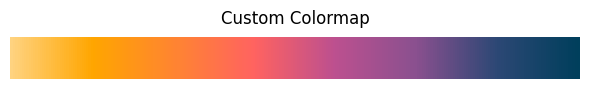

In [19]:
colors = ["#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
colors.reverse()
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

plt.figure(figsize=(6, 1))
gradient = [list(range(256))]
plt.imshow(gradient, aspect='auto', cmap=custom_cmap)
plt.axis("off")
plt.title("Custom Colormap", pad=10)
plt.tight_layout()
plt.show()

In [26]:
lh_true, lh_pred, lh_labels = train_and_report(train, test, "implicit_class", printing=False)
print(classification_report(lh_true, lh_pred, target_names=lh_labels))

                 precision    recall  f1-score   support

     incitement       0.56      0.54      0.55       265
    inferiority       0.50      0.58      0.54       153
          irony       0.59      0.57      0.58       154
          other       0.33      0.24      0.28        17
  stereotypical       0.57      0.57      0.57       231
    threatening       0.60      0.63      0.61       128
white_grievance       0.64      0.61      0.62       320

       accuracy                           0.58      1268
      macro avg       0.54      0.53      0.54      1268
   weighted avg       0.58      0.58      0.58      1268



In [20]:
mt, mp, ml = train_and_report(mami_train, mami_test, "misogyny", printing=False)
print(classification_report(mt, mp, target_names=ml))

                precision    recall  f1-score   support

    misogynous       0.84      0.86      0.85      1100
not misogynous       0.85      0.84      0.85      1099

      accuracy                           0.85      2199
     macro avg       0.85      0.85      0.85      2199
  weighted avg       0.85      0.85      0.85      2199



In [15]:
mami_true, mami_pred, mami_labels = train_and_report(mami_train, mami_test, label_cols, multilabel=True, printing=False)
print(classification_report(mami_true, mami_pred, target_names=mami_labels, zero_division=0))

                 precision    recall  f1-score   support

        shaming       0.48      0.40      0.44       285
     stereotype       0.66      0.70      0.68       613
objectification       0.67      0.70      0.68       515
       violence       0.62      0.56      0.59       242

      micro avg       0.63      0.63      0.63      1655
      macro avg       0.61      0.59      0.60      1655
   weighted avg       0.63      0.63      0.63      1655
    samples avg       0.63      0.64      0.60      1655



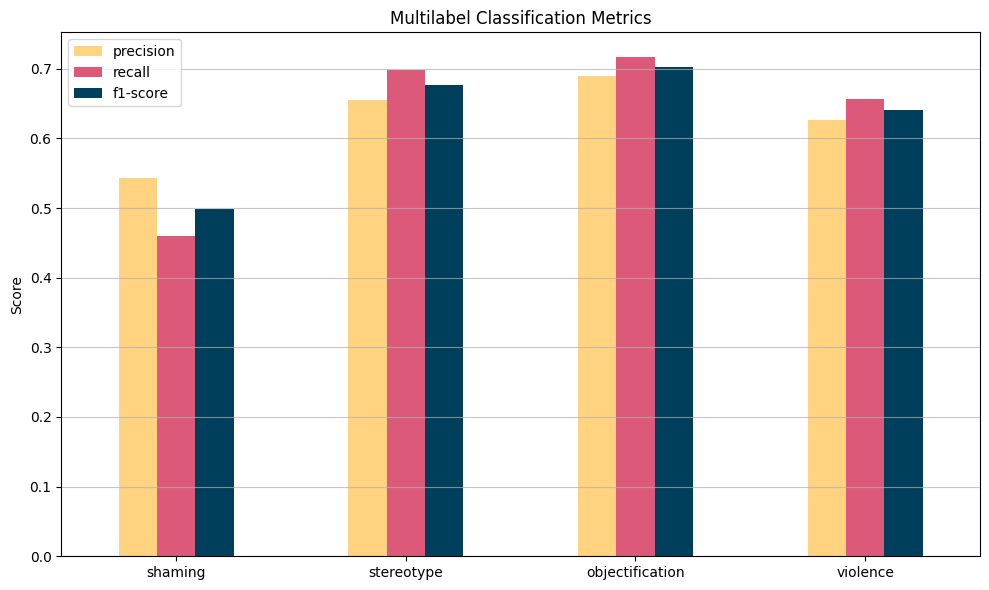

In [108]:
report_df = pd.DataFrame(report).transpose()

metrics = report_df.loc[mami_labels, ['precision', 'recall', 'f1-score']]
metrics.plot(kind='bar', figsize=(10, 6), rot=0, colormap=custom_cmap)

plt.title("Multilabel Classification Metrics")
plt.ylabel("Score")
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

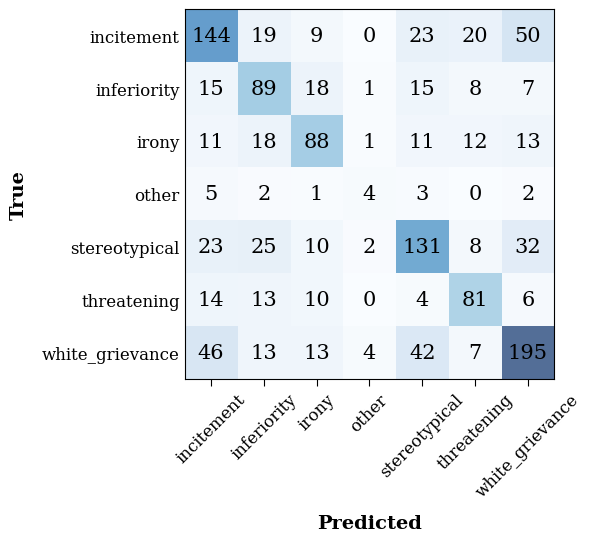

In [28]:
labels = lh_labels

conf = confusion_matrix(lh_true, lh_pred)#, normalize="true")

fig, ax = plt.subplots()

ax.matshow(conf, cmap="Blues", alpha=0.7)

for (i, j), z in np.ndenumerate(conf):
    ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center', fontsize=15, fontdict={"family": "serif"})

ax.grid(False)

ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis=u'x', which=u'both',length=5)
ax.tick_params(axis=u'y', which=u'both',length=0)

plt.xticks(range(len(labels)), labels, rotation=45, fontsize=12, fontdict={"family": "serif"}, )
plt.yticks(range(len(labels)), labels, fontsize=12, fontdict={"family": "serif"})
plt.xlabel("Predicted", labelpad=10, fontsize=14, fontdict={"weight": "bold", "family": "serif"})
plt.ylabel("True", labelpad=10, fontsize=14, fontdict={"weight": "bold", "family": "serif"})
plt.savefig("LH-CM-FT.svg", dpi=600, bbox_inches="tight", transparent=True)
plt.show()

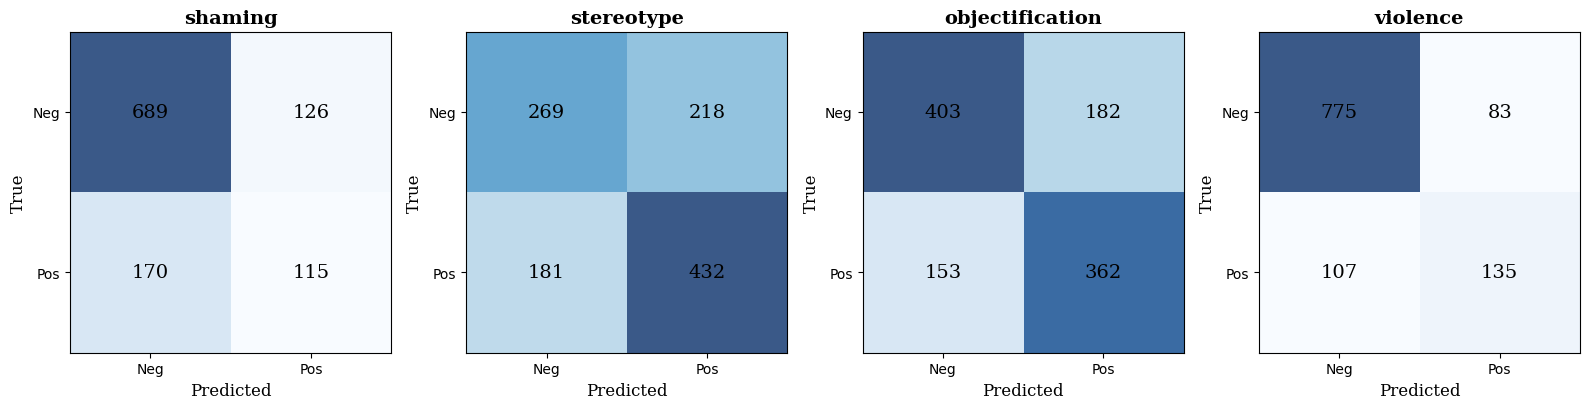

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
from matplotlib.colors import LogNorm

labels = mami_labels
cm = multilabel_confusion_matrix(mami_true, mami_pred)

fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(4 * len(labels), 4))

for idx, (label, matrix) in enumerate(zip(labels, cm)):
    ax = axes[idx] if len(labels) > 1 else axes

    row_sums = matrix.sum(axis=1, keepdims=True)
    #matrix = matrix.astype('float') / row_sums
    #matrix = np.nan_to_num(matrix) / matrix.sum()

    ax.matshow(matrix, cmap="Blues", alpha=0.8, norm=LogNorm(vmin=120))

    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, f'{z:.0f}', ha='center', va='center', fontsize=14, fontdict={"family": "serif"})

    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(f'{label}', fontsize=14, fontdict={"weight": "bold", "family": "serif"})
    ax.set_xlabel("Predicted", fontsize=12, fontdict={"family": "serif"})
    ax.set_ylabel("True", fontsize=12, fontdict={"family": "serif"})
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Neg", "Pos"])
    ax.set_yticklabels(["Neg", "Pos"])

plt.tight_layout()
plt.savefig("ML-CMs.svg", dpi=600, bbox_inches="tight", transparent=True)
plt.show()

# Error Analysis

In [41]:
train["embeddings"] = get_embeddings(train["post"])
test["embeddings"] = get_embeddings(test["post"])

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [50]:
train["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(train["post"]), get_embeddings(train["response"]))]
test["embeddings"] = [np.concatenate([a, b]) for a, b in zip(get_embeddings(test["post"]), get_embeddings(test["response"]))]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [55]:
true, pred, labels = train_and_report(train, test, "implicit_class", printing=False)
print(classification_report(true, pred, target_names=labels))

                 precision    recall  f1-score   support

     incitement       0.55      0.57      0.56       265
    inferiority       0.50      0.58      0.53       153
          irony       0.60      0.57      0.59       154
          other       0.25      0.18      0.21        17
  stereotypical       0.59      0.59      0.59       231
    threatening       0.58      0.65      0.61       128
white_grievance       0.65      0.58      0.62       320

       accuracy                           0.58      1268
      macro avg       0.53      0.53      0.53      1268
   weighted avg       0.58      0.58      0.58      1268



In [56]:
label_dict = dict()
for i, label in enumerate(labels):
    label_dict[i] = label

In [44]:
ea = test[["post", "response", "binary_class", "implicit_class"]].copy()
ea["binary_zc"] = [label_dict[res] for res in pred]

In [53]:
ea["binary_ft"] = [label_dict[res] for res in pred]

In [48]:
reduced = test.copy().dropna(subset=["implicit_class"])
reduced["implicit_zc"] = [label_dict[res] for res in pred]

#ea["implicit_class"] = test.copy()["implicit_class"]
ea = ea.merge(reduced[["post", "implicit_zc"]], on="post", how="left")

In [57]:
reduced = test.copy().dropna(subset=["implicit_class"])
reduced["implicit_ft"] = [label_dict[res] for res in pred]

#ea["implicit_class"] = test.copy()["implicit_class"]
ea = ea.merge(reduced[["post", "implicit_ft"]], on="post", how="left")

In [58]:
ea["implicit_class"] = test["implicit_class"]
ea = ea[["post", "response", "binary_class", "binary_zc", "binary_ft", "implicit_class", "implicit_zc", "implicit_ft"]]

In [59]:
ea

,post,response,binary_class,binary_zc,binary_ft,implicit_class,implicit_zc,implicit_ft
0,the realist report : on w / robert reyvolt of ...,"""The Realist Report"" is a website and podcast ...",not_hate,not_hate,not_hate,NaN,NaN,NaN
1,we are together with the white race at present...,"This tweet expresses solidarity with the ""whit...",hate,hate,hate,incitement,incitement,incitement
2,all white . all . white . and by the way ame...,The tweet expresses a sentiment about racial d...,hate,not_hate,not_hate,incitement,incitement,incitement
3,this is the second time in american history wh...,The tweet references the demographic shift in ...,hate,not_hate,hate,incitement,incitement,incitement
4,19 enumerated powers but we the free people we...,This tweet references the enumerated powers of...,not_hate,not_hate,not_hate,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4291,"rt : or : "" how to be fashionable and thwart...",This tweet is a retweet of another tweet that ...,not_hate,not_hate,not_hate,NaN,NaN,NaN
4292,stay stron bill . the wall is not needed,"The tweet references ""Bill"" and ""the wall."" Gi...",not_hate,not_hate,not_hate,NaN,NaN,NaN
4293,thanks for putting this picture up i'm a white...,This tweet likely originates from a white Sout...,hate,hate,hate,white_grievance,white_grievance,white_grievance
4294,i am a proud white male . #shiningalight,"The phrase ""proud white male"" is often used on...",not_hate,not_hate,not_hate,NaN,NaN,NaN


In [60]:
ea.to_csv("ea.csv", index=False)

In [ ]:
ct = pd.crosstab(ea["zc"], ea["ft"])
print(ct)
print(mcnemar(ct, exact=False, correction=True))

In [126]:
bin_fp = ea[(ea["binary_class"] == "not_hate") & (ea["binary_pred"] == "hate")]
bin_fn = ea[(ea["binary_class"] == "hate") & (ea["binary_pred"] == "not_hate")]

In [127]:
bin_fn.sample(5)

,post,response,binary_class,binary_pred,implicit_class,implicit_pred
546,altrighters are already moving there . without...,"The tweet discusses ""altrighters"" moving to ce...",hate,not_hate,incitement,incitement
1799,it allows white people to be free of black cri...,This tweet likely refers to discussions around...,hate,not_hate,inferiority,white_grievance
2166,"rt racial separation would mean the end of ""...",This tweet discusses racial separation as a po...,hate,not_hate,white_grievance,incitement
3590,ethnic norwegians disappearing as non-white co...,The tweet references the conspiracy theory of ...,hate,not_hate,white_grievance,white_grievance
3004,that is so funny. #obama wants to take my #2a ...,This tweet references Barack Obama and the Sec...,hate,not_hate,irony,irony


## MAMI

In [16]:
mami_train["embeddings"] = get_embeddings(list(zip(mami_train["extracted text"], mami_train["image description"])))
mami_test["embeddings"] = get_embeddings(list(zip(mami_test["extracted text"], mami_test["image description"])))

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [28]:
#mt, mp, ml = train_and_report(mami_train, mami_test, "misogyny", printing=False)
mt, mp, ml = train_and_report(mami_train, mami_test, label_cols, multilabel=True, printing=False)
print(classification_report(mt, mp, target_names=ml, zero_division=0))

                 precision    recall  f1-score   support

        shaming       0.46      0.40      0.43       285
     stereotype       0.67      0.73      0.70       613
objectification       0.65      0.70      0.67       515
       violence       0.60      0.53      0.56       242

      micro avg       0.62      0.64      0.63      1655
      macro avg       0.60      0.59      0.59      1655
   weighted avg       0.62      0.64      0.63      1655
    samples avg       0.63      0.65      0.60      1655



In [29]:
label_dict = dict()
for i, label in enumerate(ml):
    label_dict[i] = label

In [24]:
mea = mami_test[["meme id", "extracted text", "image description", "response", "misogyny"]].copy().reset_index(drop=True)

In [25]:
mea["binary_zc"] = [label_dict[res] for res in mp]

In [30]:
mea["multi"] = [",".join([row["shaming"], row["stereotype"], row["objectification"], row["violence"]])
                for _, row in mami_test[label_cols].astype(str).iterrows()]

miso = mea[mea["misogyny"] == "misogynous"].copy().reset_index(drop=True)
miso["multi_zc"] = [",".join(pred.astype(str)) for pred in mp]

mea = mea.merge(miso[["extracted text", "multi_zc"]], on="extracted text", how="left")
mea = mea.drop_duplicates(subset=["extracted text", "image description"])
mea.fillna({"multi_zc": "0,0,0,0"}, inplace=True)

In [31]:
mea

,meme id,extracted text,image description,response,misogyny,binary_zc,multi,multi_zc
0,7552.jpg,PROGRAMMER\nWho are you?\nBUG\nI'M BUG IN YOUR...,The cartoon character with glowing green skin ...,"The meme uses a scene from Batman Beyond, wher...",not misogynous,not misogynous,"0,0,0,0","0,0,0,0"
1,8140.jpg,"""LET'S STAY\nFRIENDS""\nHAS A DATE\nWITH YOUR\n...","This is a two-panel meme: in the first panel, ...",This meme uses a two-panel format. In the firs...,not misogynous,misogynous,"0,0,0,0","0,0,0,0"
2,4934.jpg,HASN'T BEEN PLAYED IN 15 YEARS\nSTILL REMEMBER...,A black VCR tape sits on a white surface.\n,The meme uses an image of a VHS tape with text...,not misogynous,misogynous,"0,0,0,0","0,0,0,0"
3,8779.jpg,IT'S ALL FUN AND GAMES\nUNTIL YOU HAVE TO GET\...,"Four people are looking down, and in the secon...",The meme uses a still from the music video for...,misogynous,misogynous,"0,0,0,1","0,0,1,1"
4,9602.jpg,and they say chivalry is dead\nMan Shoots Up P...,A man in an orange jumpsuit appears to be in a...,The meme juxtaposes an act of violent crime wi...,not misogynous,not misogynous,"0,0,0,0","0,0,0,0"
...,...,...,...,...,...,...,...,...
2200,9198.jpg,THE SECOND AMMENDMENT\nMAKING MORE WOMEN EQUAL...,A woman wearing a cowboy hat is aiming a rifle...,The meme uses a picture of a woman holding a r...,misogynous,misogynous,"0,0,0,0","0,1,1,0"
2201,8260.jpg,When the girl from the first\nvideo you watche...,A bearded animated man is looking lovingly at ...,The meme uses a screenshot from the animated s...,misogynous,not misogynous,"0,0,1,0","0,0,0,0"
2202,4815.jpg,Admit that the wage gap doesn't exist\nOR\ndra...,A man is holding a large handful of Uno cards ...,"This meme employs the ""Draw 25"" format, where ...",misogynous,misogynous,"0,1,0,0","0,1,0,0"
2203,501.jpg,STAR\nWARS\nMARVEL\nToxic 3th wave\nfeminism t...,"The grim reaper knocks on the door of Batman, ...",This meme uses a common image format where a f...,misogynous,misogynous,"0,1,0,0","0,1,0,0"


In [32]:
mami_train["embeddings"] = [np.concatenate([a, b, c]) for a, b, c in zip(get_embeddings(mami_train["extracted text"]), get_embeddings(mami_train["image description"]), get_embeddings(mami_train["response"]))]
mami_test["embeddings"] = [np.concatenate([a, b, c]) for a, b, c in zip(get_embeddings(mami_test["extracted text"]), get_embeddings(mami_test["image description"]), get_embeddings(mami_test["response"]))]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [36]:
#mt, mp, ml = train_and_report(mami_train, mami_test, "misogyny", printing=False)
mt, mp, ml = train_and_report(mami_train, mami_test, label_cols, multilabel=True, printing=False)
print(classification_report(mt, mp, target_names=ml, zero_division=0))

                 precision    recall  f1-score   support

        shaming       0.54      0.46      0.50       285
     stereotype       0.65      0.70      0.68       613
objectification       0.71      0.74      0.73       515
       violence       0.65      0.65      0.65       242

      micro avg       0.65      0.67      0.66      1655
      macro avg       0.64      0.64      0.64      1655
   weighted avg       0.65      0.67      0.66      1655
    samples avg       0.66      0.68      0.63      1655



In [34]:
label_dict = dict()
for i, label in enumerate(ml):
    label_dict[i] = label

In [35]:
mea["binary_ft"] = [label_dict[res] for res in mp]

In [37]:
miso = mea[mea["misogyny"] == "misogynous"].copy().reset_index(drop=True)
miso["multi_ft"] = [",".join(pred.astype(str)) for pred in mp]

mea = mea.merge(miso[["extracted text", "multi_ft"]], on="extracted text", how="left")
mea = mea.drop_duplicates(subset=["extracted text", "image description"])
mea.fillna({"multi_ft": "0,0,0,0"}, inplace=True)

In [39]:
mea = mea[['meme id', 'extracted text', 'image description', 'response', 
          'misogyny', 'binary_zc', 'binary_ft', 'multi', 'multi_zc', 'multi_ft']]
mea

,meme id,extracted text,image description,response,misogyny,binary_zc,binary_ft,multi,multi_zc,multi_ft
0,7552.jpg,PROGRAMMER\nWho are you?\nBUG\nI'M BUG IN YOUR...,The cartoon character with glowing green skin ...,"The meme uses a scene from Batman Beyond, wher...",not misogynous,not misogynous,not misogynous,"0,0,0,0","0,0,0,0","0,0,0,0"
1,8140.jpg,"""LET'S STAY\nFRIENDS""\nHAS A DATE\nWITH YOUR\n...","This is a two-panel meme: in the first panel, ...",This meme uses a two-panel format. In the firs...,not misogynous,misogynous,not misogynous,"0,0,0,0","0,0,0,0","0,0,0,0"
2,4934.jpg,HASN'T BEEN PLAYED IN 15 YEARS\nSTILL REMEMBER...,A black VCR tape sits on a white surface.\n,The meme uses an image of a VHS tape with text...,not misogynous,misogynous,not misogynous,"0,0,0,0","0,0,0,0","0,0,0,0"
3,8779.jpg,IT'S ALL FUN AND GAMES\nUNTIL YOU HAVE TO GET\...,"Four people are looking down, and in the secon...",The meme uses a still from the music video for...,misogynous,misogynous,misogynous,"0,0,0,1","0,0,1,1","0,0,1,1"
4,9602.jpg,and they say chivalry is dead\nMan Shoots Up P...,A man in an orange jumpsuit appears to be in a...,The meme juxtaposes an act of violent crime wi...,not misogynous,not misogynous,not misogynous,"0,0,0,0","0,0,0,0","0,0,0,0"
...,...,...,...,...,...,...,...,...,...,...
2200,9198.jpg,THE SECOND AMMENDMENT\nMAKING MORE WOMEN EQUAL...,A woman wearing a cowboy hat is aiming a rifle...,The meme uses a picture of a woman holding a r...,misogynous,misogynous,misogynous,"0,0,0,0","0,1,1,0","0,1,0,0"
2201,8260.jpg,When the girl from the first\nvideo you watche...,A bearded animated man is looking lovingly at ...,The meme uses a screenshot from the animated s...,misogynous,not misogynous,misogynous,"0,0,1,0","0,0,0,0","0,0,0,0"
2202,4815.jpg,Admit that the wage gap doesn't exist\nOR\ndra...,A man is holding a large handful of Uno cards ...,"This meme employs the ""Draw 25"" format, where ...",misogynous,misogynous,misogynous,"0,1,0,0","0,1,0,0","0,1,0,1"
2203,501.jpg,STAR\nWARS\nMARVEL\nToxic 3th wave\nfeminism t...,"The grim reaper knocks on the door of Batman, ...",This meme uses a common image format where a f...,misogynous,misogynous,misogynous,"0,1,0,0","0,1,0,0","0,1,0,0"


In [40]:
mea.to_csv("mea.csv", index=False)

In [139]:
for zc, ft in zip(["zc 0", "zc 1", "zc 2", "zc 3"], ["ft 0", "ft 1", "ft 2", "ft 3"]):
    ct = pd.crosstab(mea[zc], mea[ft])
    print(mcnemar(ct, exact=False, correction=True))
    print()

pvalue      0.2355589199240761
statistic   1.4069767441860466

pvalue      0.4402662823371424
statistic   0.5955882352941176

pvalue      0.8452520242196513
statistic   0.0380952380952381

pvalue      0.1272626636204396
statistic   2.3255813953488373



In [83]:
label_dict

{0: 'shaming', 1: 'stereotype', 2: 'objectification', 3: 'violence'}

In [25]:
ct = pd.crosstab(mea["zc"], mea["fi"])
print(mcnemar(ct, exact=False, correction=True))

pvalue      0.24050966678487745
statistic   1.3776041666666667
